# Part 1: Baseline Model Development 
### Introduction

This notebook implements a **baseline regression and image classification model** using TensorFlow/Keras.

**Dataset Overview:**
- **Name:** Human face emotions Computer Vision Model
- **Classes:** 8 categories (anger,
content,
disgust,
fear,
happy,
neutral,
sad,
surprise)
- **Image Type:** RGB color images
- **Source:** Roboflow
- **Dataset Type:** Images with bounding box coordinates and class labels in annotations.csv files
- **Link:** https://universe.roboflow.com/emotions-dectection/human-face-emotions 

**Project Goal:**
Build a baseline regression and image classification model using CNNs to first localise the object and then classify it. This baseline will serve as a benchmark for comparing more advanced techniques in Part 2.



---

## 1. Setup and Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil
from pathlib import Path
import cv2
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.10.1
GPU Available: True


---

## 2. Data Exploration & Visualization

We will be exploring the training data to understand the distribution of the classes and the size of the dataset, and visualizing the images to get a better understanding of the data.

In [180]:
data_dir = "./dataset/"

In [ ]:


data_path = Path(data_dir + 'train')
class_counts = {}

# Load annotations from CSV
annotations_df = pd.read_csv(data_path / '_annotations.csv')

# Analyze multi-annotation images (before filtering)
image_annotation_counts = annotations_df['filename'].value_counts()
total_images = len(image_annotation_counts)
single_annotation = (image_annotation_counts == 1).sum()
multi_annotation = (image_annotation_counts > 1).sum()

print(f"=== Image Annotation Analysis ===")
print(f"Total unique images: {total_images}")
print(f"Images with 1 annotation: {single_annotation} ({100*single_annotation/total_images:.1f}%)")
print(f"Images with multiple annotations: {multi_annotation} ({100*multi_annotation/total_images:.1f}%)")
print(f"Max annotations per image: {image_annotation_counts.max()}\n")



# Get unique class names from the 'class' column
CLASS_NAMES = sorted(annotations_df['class'].unique().tolist())
print(f"Classes: {CLASS_NAMES}")
print(f"Number of classes: {len(CLASS_NAMES)}")

# Count images per class
for class_name in CLASS_NAMES:
    class_count = len(annotations_df[annotations_df['class'] == class_name])
    print(f"  {class_name}: {class_count} images")
    class_counts[class_name] = class_count

# Check image sizes (sample a few unique images)
sample_filenames = annotations_df['filename'].unique()[:20]
sizes = set()
for filename in sample_filenames:
    img_path = data_path / filename
    if img_path.exists():
        with Image.open(img_path) as img:
            sizes.add(img.size)

print(f"\nImage sizes found: {sizes}")
print(class_counts)

=== Image Annotation Analysis ===
Total unique images: 6586
Images with 1 annotation: 6493 (98.6%)
Images with multiple annotations: 93 (1.4%)
Max annotations per image: 3

Classes: ['anger', 'content', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 8
  anger: 843 images
  content: 789 images
  disgust: 807 images
  fear: 840 images
  happy: 831 images
  neutral: 866 images
  sad: 831 images
  surprise: 873 images

Image sizes found: {(640, 640)}
{'anger': 843, 'content': 789, 'disgust': 807, 'fear': 840, 'happy': 831, 'neutral': 866, 'sad': 831, 'surprise': 873}


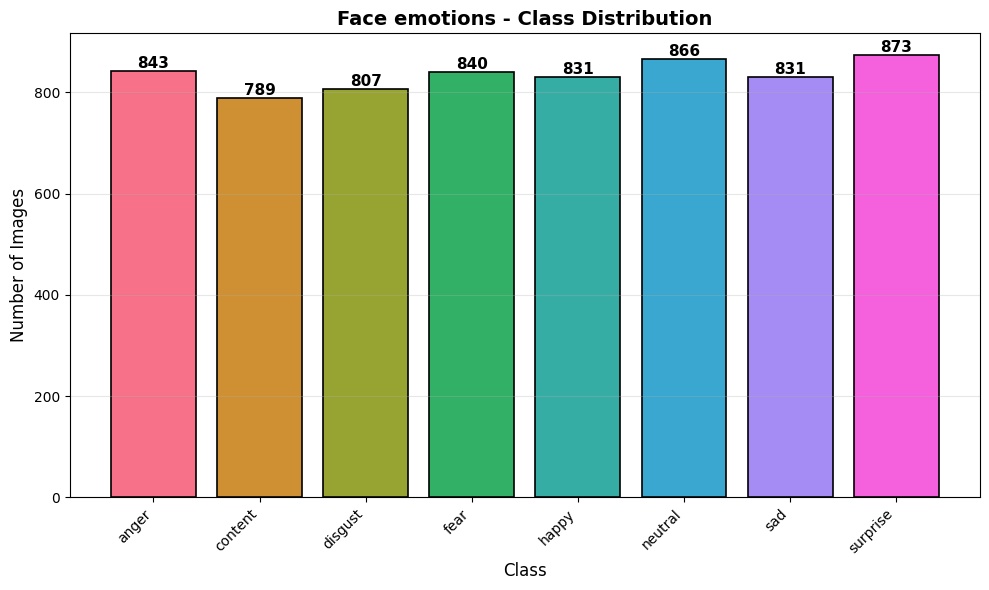

In [182]:
# Plot bar chart of class distribution
plt.figure(figsize=(10, 6))
classes = list(sorted(class_counts.keys()))
counts = [class_counts[c] for c in CLASS_NAMES]

colors = sns.color_palette('husl', n_colors=len(classes))
bars = plt.bar(classes, counts, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on top of bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Face emotions - Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

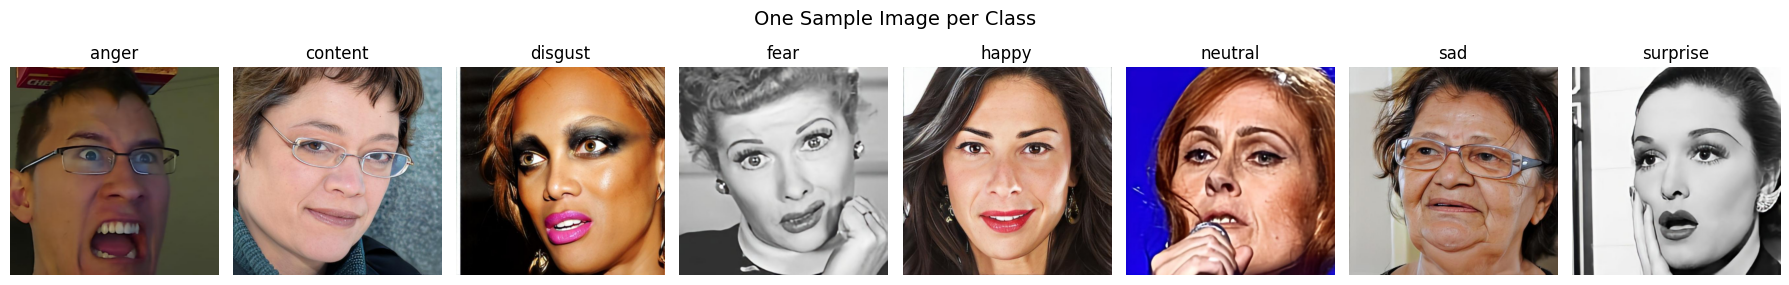

In [183]:
import matplotlib.pyplot as plt
from PIL import Image

# Show one sample image per class
fig, axes = plt.subplots(1, len(CLASS_NAMES), figsize=(18, 3))

for i, class_name in enumerate(CLASS_NAMES):
    # Get first image for this class
    filename = annotations_df[annotations_df['class'] == class_name]['filename'].iloc[0]
    img = Image.open(data_path / filename)
    
    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.suptitle('One Sample Image per Class', fontsize=14)
plt.tight_layout()
plt.show()

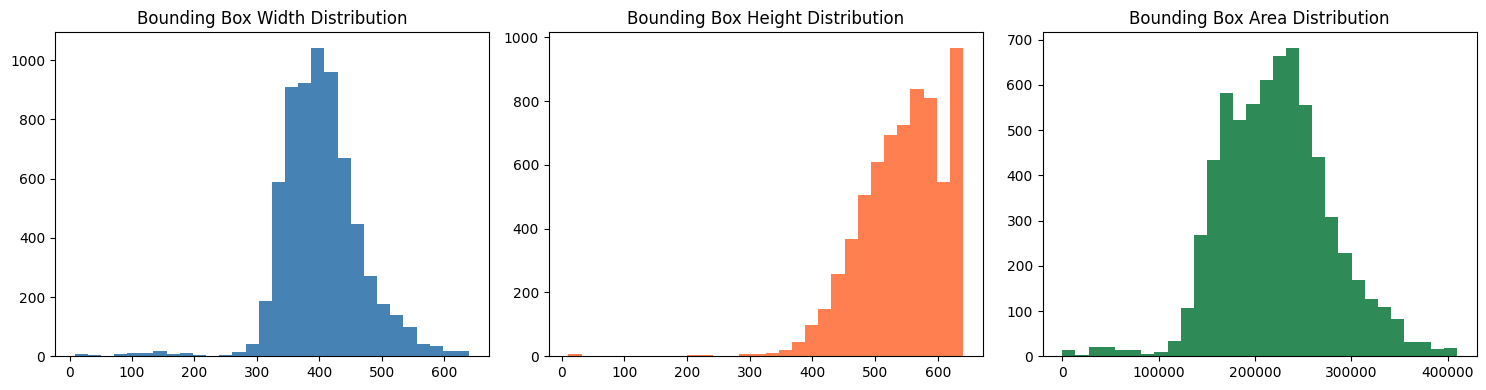

In [184]:
# Visualize bounding box sizes
annotations_df['bbox_width'] = annotations_df['xmax'] - annotations_df['xmin']
annotations_df['bbox_height'] = annotations_df['ymax'] - annotations_df['ymin']
annotations_df['bbox_area'] = annotations_df['bbox_width'] * annotations_df['bbox_height']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(annotations_df['bbox_width'], bins=30, color='steelblue')
axes[0].set_title('Bounding Box Width Distribution')
axes[1].hist(annotations_df['bbox_height'], bins=30, color='coral')
axes[1].set_title('Bounding Box Height Distribution')
axes[2].hist(annotations_df['bbox_area'], bins=30, color='seagreen')
axes[2].set_title('Bounding Box Area Distribution')
plt.tight_layout()
plt.show()

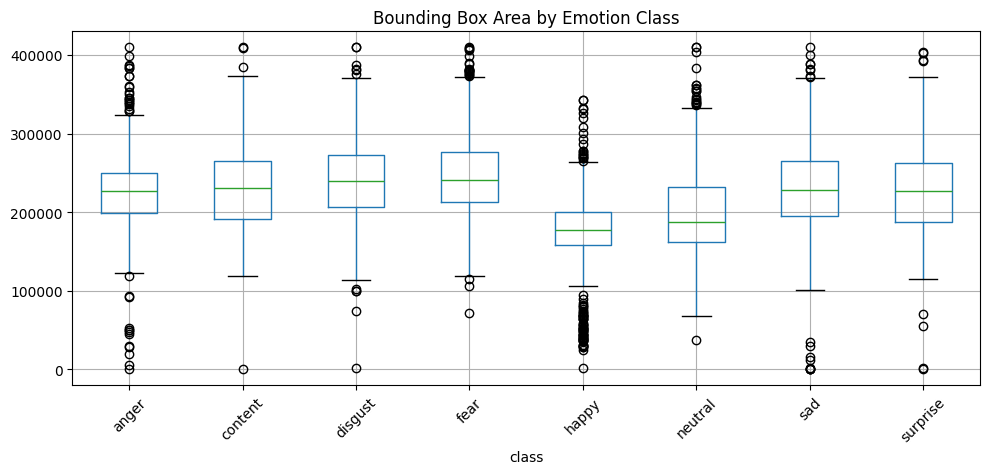

In [185]:
fig, ax = plt.subplots(figsize=(10, 5))
annotations_df.boxplot(column='bbox_area', by='class', ax=ax)
plt.suptitle('')
plt.title('Bounding Box Area by Emotion Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

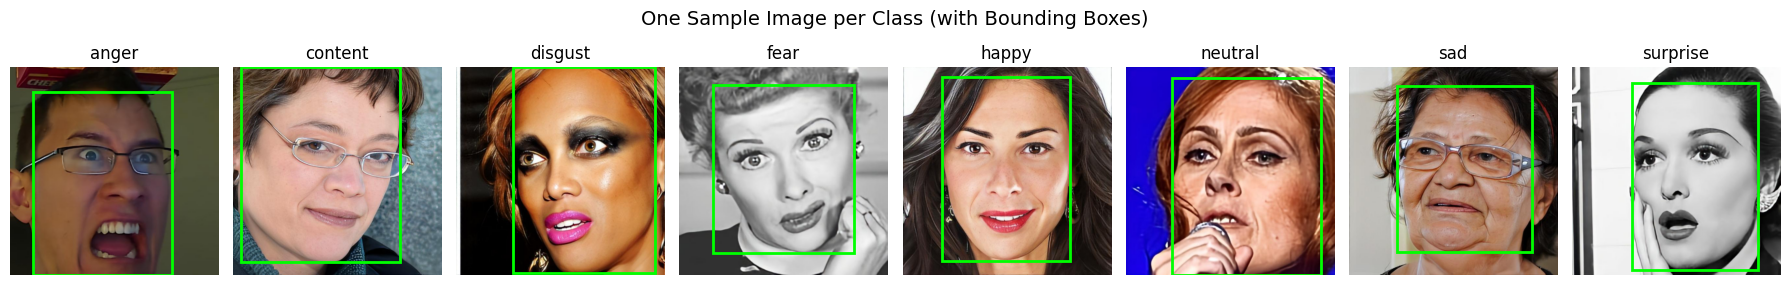

In [186]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Show one sample image per class with bounding boxes
fig, axes = plt.subplots(1, len(CLASS_NAMES), figsize=(18, 3))

for i, class_name in enumerate(CLASS_NAMES):
    # Get first row for this class (includes bbox coordinates)
    row = annotations_df[annotations_df['class'] == class_name].iloc[0]
    img = Image.open(data_path / row['filename'])
    
    axes[i].imshow(img)
    
    # Draw bounding box
    rect = patches.Rectangle(
        (row['xmin'], row['ymin']),  # (x, y) top-left corner
        row['xmax'] - row['xmin'],    # width
        row['ymax'] - row['ymin'],    # height
        linewidth=2, 
        edgecolor='lime', 
        facecolor='none'
    )
    axes[i].add_patch(rect)
    
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.suptitle('One Sample Image per Class (with Bounding Boxes)', fontsize=14)
plt.tight_layout()
plt.show()

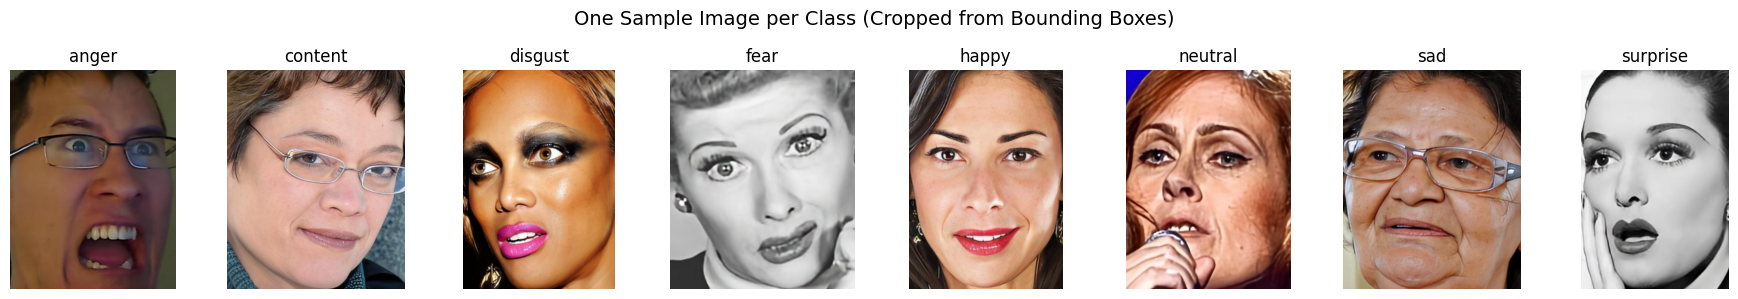

In [187]:
import matplotlib.pyplot as plt
from PIL import Image

# Show one sample image per class with cropped bounding boxes
fig, axes = plt.subplots(1, len(CLASS_NAMES), figsize=(18, 3))

for i, class_name in enumerate(CLASS_NAMES):
    # Get first row for this class (includes bbox coordinates)
    row = annotations_df[annotations_df['class'] == class_name].iloc[0]
    img = Image.open(data_path / row['filename'])
    
    # Crop the image using the bounding box coordinates
    cropped_img = img.crop((row['xmin'], row['ymin'], row['xmax'], row['ymax']))
    
    axes[i].imshow(cropped_img)
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.suptitle('One Sample Image per Class (Cropped from Bounding Boxes)', fontsize=14)
plt.tight_layout()
plt.show()

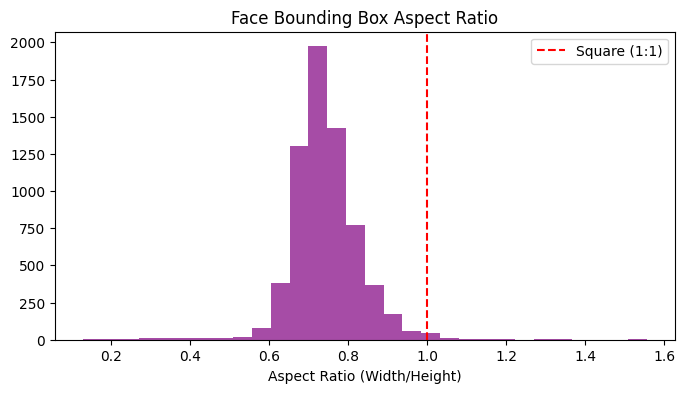

In [188]:
annotations_df['aspect_ratio'] = annotations_df['bbox_width'] / annotations_df['bbox_height']
plt.figure(figsize=(8, 4))
plt.hist(annotations_df['aspect_ratio'], bins=30, color='purple', alpha=0.7)
plt.axvline(x=1.0, color='red', linestyle='--', label='Square (1:1)')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.title('Face Bounding Box Aspect Ratio')
plt.legend()
plt.show()

### Data Quality Observations

**Class Balance:**
- The dataset shows relatively balanced class distribution, though some variation exists.
- No class appears to be severely underrepresented, which is good for training without class weights.

**Image Quality:**
- All images are RGB (3-channel color images) as seen above.
- All images are of the same size (640x640) as seen above.
- Some images may have noise or compression artifacts, which is typical of real-world data. (Hats, Guns, Extra Objects)
- Some images may be grey scale images, but in the later preprocessing steps, we will convert them to RGB to ensure the correct image format.
- All the images consist of faces that take up most of the image. 

**Bounding Boxes**
- The height, width, and area of the bounding boxes are generally similar.
- The height distribution of the bounding boxes shows a strong skew to the left. This means that the bounding box occupies nearly the entire height of the image.
- The area distribution shows a Gaussian (Normal) pattern. This means that the bounding boxes occupy a similar amount of space in the image.
- The width distribution shows a Gaussian pattern. This means that unlike the height distribution, the bounding box does not take up the entire width of the image.
- We can see some images has multiple annotations, this is because some images have multiple faces in them.


**Potential Challenges:**
- **Big Image Size** The images in the dataset are relatively large (640x640).
- **Subjective Labels** As seen in the images like in the fear class, some people may not label it as fear but a different class like surprised for example.
- **Lighting and Different Poses** Some images have different lighting conditions and the faces have different poses (e.g. Hand on the face).
- **Model Generalisation** Since the bounding boxes' height distribution is skewed to the left, it shows that most bounding boxes take up the entire height of the image. This can cause the model to not be able to predict faces that may not take up the entire height of the image.
- **Multiple Annotations** Since we are only using a basic CNN model, it can only predict one output of the bounding box coordinates per image. 
- **Faces are too close** Since all of the images have faces that take up most the of the image, the model will only be aware of and trained on bounding boxes that take up most of the image. So when the model sees an image that has a face that is not taking up most of the image, it will not be able to predict the bounding box coordinates.

**Conclusion:** The dataset is suitable for baseline classification. Data augmentation, data preprocessing, and data cleaning will help the model generalize to variations in the data.

---

## 3. Data Pre-processing

### Splitting the dataset for training, testing, and validation.

The dataset's structure already has train, test, and validation sets so we don't need to split them. However, since we are going to be using 2 models, the locator model and the classifier model, we will need to have the dataset be split according for these models. 

Firstly for the locator (regression) model, we will need to load the full images and also store the bounding box coordinates of the object in a seperate variable.

Secondly for the classification model, we will need to load the cropped the images (based on the coordinates of the bounding box) and then store the associating classes of the images in a separate variable.

In [189]:
IMG_SIZE = 64
BATCH_SIZE = 16

I will be using a downscaled image sise of (128,128).

The reasons are:
- **Significant Downscaling** Downscaling the image sise from 640x640 to 128x128 is a significant reduction in sise, which can lead to faster loading and processing times due to being less computationally expensive.
- **Preserves Sufficient Facial Details** The image sise of 128x128 is still large enough to preserve sufficient facial details for accurate classification.
- **Efficient for Simple CNNs** Since the use of pre-trained and complex CNNs are not allowed, having a smaller image size allows for simple CNNs to learn more effectively.
- **No Effect On Model Performance** The model performance is not affected by the downscaling as I've tried 128x128 image size and 64x64 performed the same if not better.


I will be using the batch size of 16.

The reasons are:
- **Memory Efficient** Takes less memory compared to higher batch sizes.
- **Better generalization:** Avoids overfitting to small details
- **Proven:** As seen in the appendix and table of documents, the batch size of 16 performed the best.


In [190]:
import cv2
import numpy as np

def add_padding(image, bbox, scale_factor=2.0):

    h, w = image.shape[:2]
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
    
    # Calculate padding
    pad_top = (new_h - h) // 2
    pad_bottom = new_h - h - pad_top
    pad_left = (new_w - w) // 2
    pad_right = new_w - w - pad_left
    
    # Pad image 
    padded_image = cv2.copyMakeBorder(
        image, pad_top, pad_bottom, pad_left, pad_right,
        cv2.BORDER_CONSTANT, value=[0, 0, 0] 
    )
    
    # Adjust bounding box coordinates
    new_bbox = [
        bbox[0] + pad_left,  
        bbox[1] + pad_top,   
        bbox[2],             
        bbox[3]              
    ]
    
    
    # Normalise
    new_bbox_normalised = [
        new_bbox[0] / new_w,
        new_bbox[1] / new_h,
        new_bbox[2] / new_w,
        new_bbox[3] / new_h
    ]
    
    return padded_image, new_bbox_normalised, new_bbox

Function to add padding to images. Will adjust bounding box coordinates accordingly.

In [191]:
def load_and_process_data(csv_path, img_dir):
    # Load CSV 
    try:
        df = pd.read_csv(csv_path)
    except:
        df = pd.read_csv(csv_path, sep=';')

    images_full = []
    boxes_norm = []
    images_crop = []
    labels = []
    
    print(f'Loading images from {img_dir}')

    # Check if CSV is empty
    if df.empty:
        print("CSV file is empty!")
        return None, None, None, None, None, None

    # Pre-filter: Keep only largest bbox per image
    df['bbox_area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])
    df = df.loc[df.groupby('filename')['bbox_area'].idxmax()]
    
    # Filter out very small bboxes
    min_area = 100 * 100
    df = df[df['bbox_area'] >= min_area]
    df = df.drop(columns=['bbox_area'])

    for index, row in df.iterrows():

        img_path = os.path.join(img_dir, row['filename'])

        # Check if image exists
        if not os.path.exists(img_path):
            if index < 3: 
                print(f"ERROR: Image not found at {img_path}")
            continue

        # Read Image
        img = cv2.imread(img_path)
        if img is None: 
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        #Load and save original bbox coordinates
        x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        bbox = [x1, y1, x2 - x1, y2 - y1]

        # Validate bounding box FIRST (before appending anything)
        if x1 >= x2 or y1 >= y2:
            continue

        if random.random() < 0.5:
            img, bbox_normalised, bbox = add_padding(img, bbox, scale_factor=2.0)
            h, w = img.shape[:2]
            crop_x, crop_y, crop_w, crop_h = bbox

            
            crop = img[crop_y:crop_y+crop_h, crop_x:crop_x+crop_w]
            

        else:
            # Keep original, just normalize bbox
            h, w = img.shape[:2]
            bbox_normalised = [bbox[0]/w, bbox[1]/h, bbox[2]/w, bbox[3]/h]


            crop = img[y1:y2, x1:x2]

        #Validate crop
        if crop.size == 0: 
            continue


        # Prepare data for locator model
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images_full.append(img_resized / 255.0)
        boxes_norm.append(bbox_normalised)

    


        # Prepare data for classifier model
        crop_resized = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
        images_crop.append(crop_resized / 255.0)
        
        labels.append(row['class'])

    if len(labels) == 0:
        print("\nNo images were loaded.")
        print("Check if 'DATA_DIR' variable matches your actual folder path.")
        return None, None, None, None, None, None

    # Convert to Numpy Arrays
    X_full = np.array(images_full)
    Y_boxes = np.array(boxes_norm)
    X_crops = np.array(images_crop)

    # Encode labels
    classes = sorted(list(set(labels))) 
    class_map = {c: i for i, c in enumerate(classes)}
    Y_classes = np.array([class_map[l] for l in labels])

    print(f"Loaded {len(X_full)} images. Found {len(classes)} classes.")
    print(f"Arrays synchronized: X_full={len(X_full)}, X_crops={len(X_crops)}, Y_boxes={len(Y_boxes)}, Y_classes={len(Y_classes)}")
    
    return X_full, Y_boxes, X_crops, Y_classes, classes, class_map

In [192]:
DATASET_BASE = r"dataset"


# Load Training Data 
TRAIN_DIR = os.path.join(DATASET_BASE, "train")
TRAIN_CSV = os.path.join(TRAIN_DIR, "_annotations.csv")
X_full_train, Y_boxes_train, X_crops_train, Y_classes_train, classes, class_map = load_and_process_data(TRAIN_CSV, TRAIN_DIR)

# Load Validation Data
VALID_DIR = os.path.join(DATASET_BASE, "valid")
VALID_CSV = os.path.join(VALID_DIR, "_annotations.csv")
X_full_val, Y_boxes_val, X_crops_val, Y_classes_val, _, _ = load_and_process_data(VALID_CSV, VALID_DIR)

# Load Test Data
TEST_DIR = os.path.join(DATASET_BASE, "test")
TEST_CSV = os.path.join(TEST_DIR, "_annotations.csv")
X_full_test, Y_boxes_test, X_crops_test, Y_classes_test, _, _ = load_and_process_data(TEST_CSV, TEST_DIR)


Loading images from dataset\train
Loaded 6584 images. Found 8 classes.
Arrays synchronized: X_full=6584, X_crops=6584, Y_boxes=6584, Y_classes=6584
Loading images from dataset\valid
Loaded 1873 images. Found 8 classes.
Arrays synchronized: X_full=1873, X_crops=1873, Y_boxes=1873, Y_classes=1873
Loading images from dataset\test
Loaded 941 images. Found 8 classes.
Arrays synchronized: X_full=941, X_crops=941, Y_boxes=941, Y_classes=941


Why convert the lists to NumPy Array?
- TensorFlow/Keras expects NumPy arrays as input, not Python lists.

Why normalise the pixels?
- Raw pixel values range 0-255
- Neural networks train better with smaller input values (0-1)
- Prevents large gradients = more stable training

Why normalise bounding boxes?
- Scale invariance (Means that it'll work for any image size)
- Model output range (Model predicts values 0-1 with sigmoid activation)
- Easier training 
- Consistent format (Images are also normalised 0-1)

Why encode the labels?
- Neural networks do not understand the word "happy". They only work with numbers which is why we encode the labels to have numbers represent the classes.

Why filter the annotations?
- CNNs can only predict one bounding box coordinate per image, so we only keep the first and largest annotation of each image

Why add padding to images?
- As the dataset consists of images where the face takes up the entire image, the model will not be able to learn to predict the location of the face if the face is too small as it has never seen any data like it. So, I added padding to half of the images to make the faces and bounding box area smaller so that the model is able to generalise better.

---

Now we will check and make sure that the images and labels are loaded correctly.

In [193]:

print(f"Train - Locator: {X_full_train.shape}, Classifier: {X_crops_train.shape}")
print(f"Valid - Locator: {X_full_val.shape}, Classifier: {X_crops_val.shape}")
print(f"Test  - Locator: {X_full_test.shape}, Classifier: {X_crops_test.shape}")
print(f"Classes ({len(classes)}): {classes}")

Train - Locator: (6584, 64, 64, 3), Classifier: (6584, 64, 64, 3)
Valid - Locator: (1873, 64, 64, 3), Classifier: (1873, 64, 64, 3)
Test  - Locator: (941, 64, 64, 3), Classifier: (941, 64, 64, 3)
Classes (8): ['anger', 'content', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Locator samples: 6584
Classifier samples: 6584


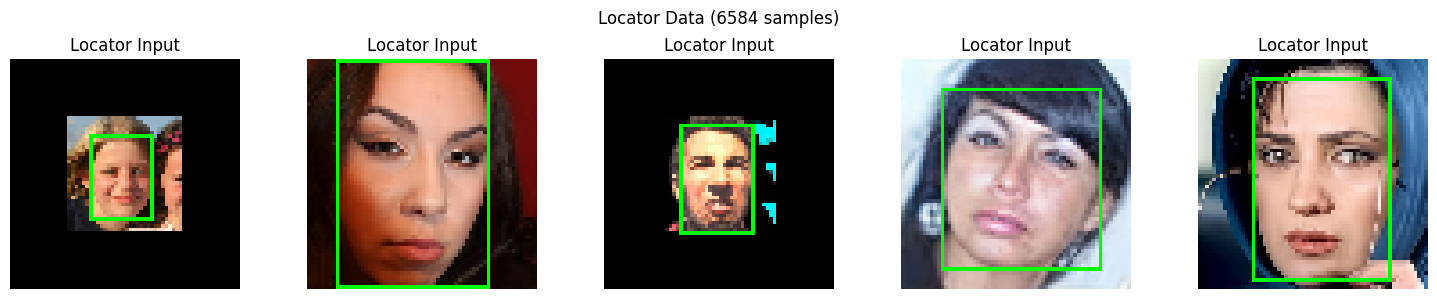

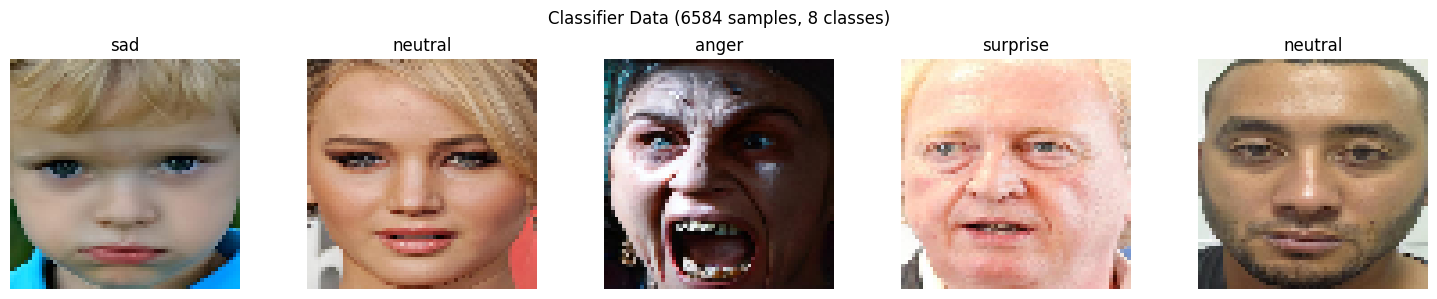

In [194]:
# === SEPARATE VISUALIZATIONS ===

# 1. Locator samples (full images with boxes)
def visualize_locator(X_f, y_b, idxs):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        plt.subplot(1, 5, i + 1)
        img = X_f[idx].copy()
        h, w, _ = img.shape
        bx, by, bw, bh = y_b[idx]
        x1, y1 = int(bx * w), int(by * h)
        x2, y2 = int((bx + bw) * w), int((by + bh) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
        plt.imshow(img)
        plt.title("Locator Input")
        plt.axis('off')
    plt.suptitle(f"Locator Data ({len(X_f)} samples)")
    plt.tight_layout()
    plt.show()

# 2. Classifier samples (cropped faces)
def visualize_classifier(X_c, Y_c, class_names, idxs):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_c[idx])
        plt.title(f"{class_names[Y_c[idx]]}")
        plt.axis('off')
    plt.suptitle(f"Classifier Data ({len(X_c)} samples, {len(class_names)} classes)")
    plt.tight_layout()
    plt.show()

# === VISUALIZE ===
print(f"Locator samples: {len(X_full_train)}")
print(f"Classifier samples: {len(X_crops_train)}")

visualize_locator(X_full_train, Y_boxes_train, np.random.randint(0, len(X_full_train), 5))
visualize_classifier(X_crops_train, Y_classes_train, classes, np.random.randint(0, len(X_crops_train), 5))

--- 
### Pixel intensity distribution

Before and After Normalisation/Rescaling

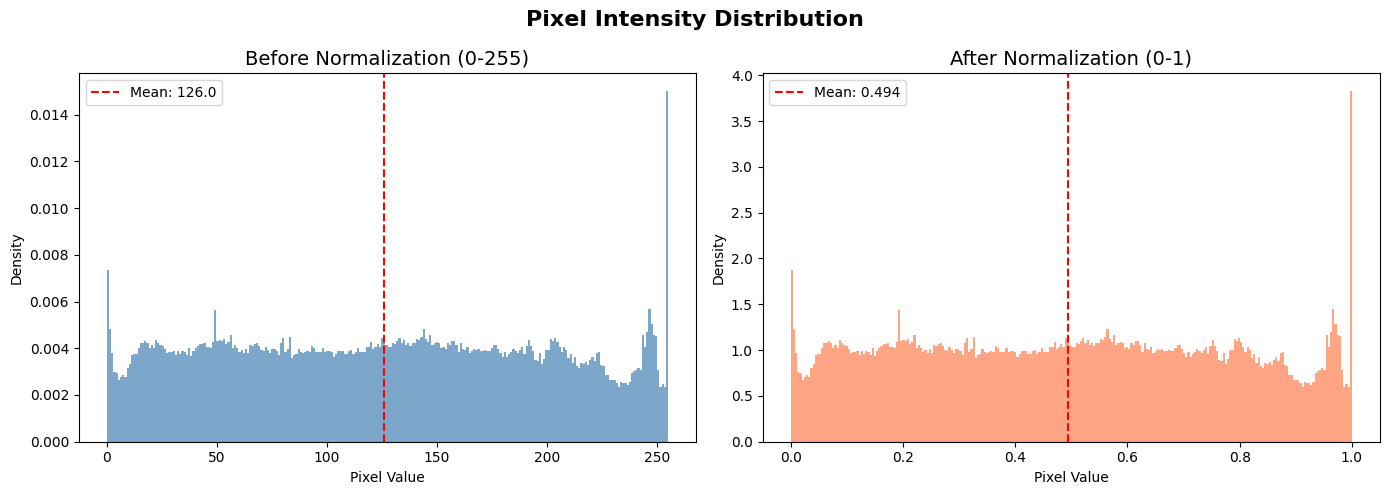

In [195]:


import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from pathlib import Path

# Load sample images
data_path = Path(data_dir + 'train')
df = pd.read_csv(data_path / '_annotations.csv').drop_duplicates(subset='filename').head(32)

raw_images = []
for _, row in df.iterrows():
    img = cv2.imread(str(data_path / row['filename']))
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        raw_images.append(img)

raw_images = np.array(raw_images)
normalized_images = raw_images / 255.0

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(raw_images.ravel(), bins=256, range=(0, 255), color='steelblue', alpha=0.7, density=True)
axes[0].axvline(x=raw_images.mean(), color='red', linestyle='--', label=f'Mean: {raw_images.mean():.1f}')
axes[0].set_title("Before Normalization (0-255)", fontsize=14)
axes[0].set_xlabel("Pixel Value")
axes[0].set_ylabel("Density")
axes[0].legend()

axes[1].hist(normalized_images.ravel(), bins=256, range=(0, 1), color='coral', alpha=0.7, density=True)
axes[1].axvline(x=normalized_images.mean(), color='red', linestyle='--', label=f'Mean: {normalized_images.mean():.3f}')
axes[1].set_title("After Normalization (0-1)", fontsize=14)
axes[1].set_xlabel("Pixel Value")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.suptitle("Pixel Intensity Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

As seen above, normalisation makes the pixel values range from 0 to 1. This allows for stable training, faster convergence, and better generalization as activation functions work best with small values.

### Data Augmentation Strategy

We will only be augmenting the data going into the classifier model and not the locator model. This is because we need to retain the bounding box coordinates for the locator model and augmenting the data can cause the bounding box coordinates to be incorrect.

**Training Set Augmentation:**
- `rotation_range=10`: Slight rotations (+ or - 10 degrees) to handle camera tilt variations
- `horizontal_flip=True`: Mirror images since scenes look valid from either side
- `width_shift_range=0.05, height_shift_range=0.05`: Slight horizontal/vertical shifts to handle camera position variations
- `zoom_range=0.05`: Slight zoom variations to handle different distances

**Why These Augmentations?**
- **Conservative approach:** We use mild augmentations for the baseline to avoid introducing too much noise.
- **Prevent overfitting:** Augmentation artificially expands the dataset, reducing memorization.

**Validation/Test Sets:**
- Only rescaling is applied (no augmentation) to evaluate on realistic data distributions.

In [196]:
# MILDER augmentation settings
train_datagen = ImageDataGenerator(
    rotation_range=30,        
    width_shift_range=0.2,   
    height_shift_range=0.2,  
    horizontal_flip=True,
    zoom_range=0.1         
)


train_generator = train_datagen.flow(
    X_crops_train,    # Cropped face images
    Y_classes_train,  # Emotion labels
    batch_size=BATCH_SIZE
)

Batch shape: (16, 64, 64, 3)
Pixel range: [0.000, 1.000]
Mean: 0.479


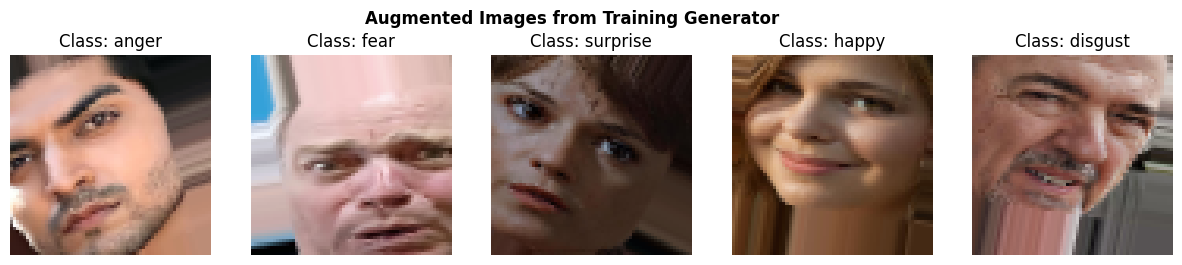

In [197]:
# Check a batch from the generator
sample_batch, sample_labels = next(train_generator)

print(f"Batch shape: {sample_batch.shape}")
print(f"Pixel range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
print(f"Mean: {sample_batch.mean():.3f}")

# Display images from the generator (these will work!)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(sample_batch[i])
    ax.set_title(f"Class: {classes[sample_labels[i]]}")
    ax.axis('off')
plt.suptitle("Augmented Images from Training Generator", fontweight='bold')
plt.show()

---

## 4. Baseline Locator Model

### Architecture Overview

I will be using custom simple CNN architecture for both classifier and locator models. However, variations of the baseline architectures are visited including add dropout, batch normalization, and different activation functions and can be found in the appendix.

For the locator model, I will be creating a CNN regression model to predict the bounding box coordinates of the object of interest. It will use an IoU (Intersection over Union) metric to evaluate the performance of the model. It measures how much overlap does the predicted box have with the ground truth box.

For the classifier model, I will be creating a CNN classification model to predict the class of the object of interest. It will use an accuracy metric to evaluate the performance of the model.






In [198]:
def iou_metric(y_true, y_pred):
    # This function calculates how well the box overlaps the target
    # 1. Convert (x, y, w, h) to (x1, y1, x2, y2)
    box1_x1 = y_true[:, 0]
    box1_y1 = y_true[:, 1]
    box1_x2 = y_true[:, 0] + y_true[:, 2]
    box1_y2 = y_true[:, 1] + y_true[:, 3]

    box2_x1 = y_pred[:, 0]
    box2_y1 = y_pred[:, 1]
    box2_x2 = y_pred[:, 0] + y_pred[:, 2]
    box2_y2 = y_pred[:, 1] + y_pred[:, 3]

    # 2. Intersection Area
    xi1 = tf.maximum(box1_x1, box2_x1)
    yi1 = tf.maximum(box1_y1, box2_y1)
    xi2 = tf.minimum(box1_x2, box2_x2)
    yi2 = tf.minimum(box1_y2, box2_y2)
    
    inter_width = tf.maximum(0.0, xi2 - xi1)
    inter_height = tf.maximum(0.0, yi2 - yi1)
    inter_area = inter_width * inter_height

    # 3. Union Area
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area

    return inter_area / (union_area + 1e-7)

In [199]:
def build_locator_model():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),

        layers.Dense(4, activation='sigmoid') 
    ])
    
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.Huber(delta=0.1),  
        metrics=[iou_metric]                   
    )
    
    return model

locator_model = build_locator_model()

In [200]:
def build_classifier_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(8, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),


        layers.Conv2D(32, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        # layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

classifier_model = build_classifier_model(len(CLASS_NAMES))


### Model Justification

**Why Use ReLU?**
- Non-linear activation function
- Prevents vanishing gradient
- Leads to better model performance on unseen data
- When tested amongst other activation functions (Elu, tanh, sigmoid), ReLU performed better.

**Layers**

- Conv2D: Used to detect high to low-level features like edges and curves.

- MaxPooling: Used to reduce spatial dimensions and provide translation invariance.

- Flatten: Bridges the convolutional feature extractor with the dense classification head.

While adding dropout layers or batch normalisation layers to the model seems like it would improve the model, my testing shows that it does not. Adding dropout and batch normalisation to the FCLs made the model get a 0.47 accuracy and adding batch normalisation to the Conv layers made the model get a 0.42 accuracy. Instead, it made the model perform worse. Refer to the appendix for more details.



In [201]:

locator_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [202]:
classifier_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 8)         224       
                                                                 
 activation_10 (Activation)  (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 16)        1168      
                                                                 
 activation_11 (Activation)  (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                 

### Compilation: Optimiser and Loss Function

**Why Use RMSprop Optimiser?**
- Adaptive learning rate
- Handles varying gradient magnitudes
- When tested amongst other optimisers (Adam, SGD), RMSprop performed better.

**Why Sparse Categorical Crossentropy?**

- Standard loss function for multi-class classification with softmax output
- Measures the divergence between predicted probability distribution and true one-hot labels
- Encourages the model to assign high probability to the correct class
- sparse_categorical_crossentropy instead of categorical_crossentropy because the labels are integers, not one-hot encoded vectors.

**Why Learning Rate of 0.001?**

- It allows for finer updates within the model's parameters, leading to more stable convergence.
- Learning rate of 0.001 yielded better results compared to other learning rates (0.01, 0.1).

---

## 5. Training

### Early Stopping Callback

I use Early Stopping to:
- **Prevent overfitting:** Stop training when validation loss stops improving
- **Save computation:** No need to train for a fixed number of epochs
- **Automatic best model:** Restore weights from the best epoch

**Parameters:**
- `monitor='val_loss'`: Watch validation loss (better than accuracy for detecting overfitting)
- `patience=5`: Wait 5 epochs without improvement before stopping
- `restore_best_weights=True`: Use the best model weights, not the last epoch

### ReduceLROnPlateau Callback
I use ReduceLROnPlateau to:

- **Escape plateaus:** Automatically reduce learning rate when training stalls
- **Fine-tune convergence:** Smaller learning rates allow more precise weight updates near the optimum
- **Adaptive scheduling:** No need to manually define a learning rate schedule

**Parameters:**

- `monitor='val_loss'`: Watch validation loss to detect when learning has stalled
- `factor=0.2`: Reduce learning rate by 80% (new_lr = old_lr × 0.2) when triggered
- `patience=3`: Wait 3 epochs without improvement before reducing the learning rate
- `min_lr=1e-6`: Set a floor to prevent the learning rate from becoming too small
- `verbose=1`: Print a message when the learning rate is reduced for transparency


In [203]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# EarlyStopping: Stops training if the model stops improving for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: Lowers the learning rate if the model gets stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6,
    verbose=1
)





In [204]:
print("TRAINING LOCATOR MODEL (Finding Boxes)")

history_loc = locator_model.fit(
    X_full_train, Y_boxes_train,         
    validation_data=(X_full_val, Y_boxes_val), 
    epochs=30,                         
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],  
    verbose=1
)


TRAINING LOCATOR MODEL (Finding Boxes)
Epoch 1/30
412/412 [==============================] - 3s 6ms/step - loss: 0.0017 - iou_metric: 0.7503 - val_loss: 0.0011 - val_iou_metric: 0.8105 - lr: 0.0010
Epoch 2/30
412/412 [==============================] - 2s 5ms/step - loss: 9.4816e-04 - iou_metric: 0.8153 - val_loss: 8.3121e-04 - val_iou_metric: 0.8305 - lr: 0.0010
Epoch 3/30
412/412 [==============================] - 2s 5ms/step - loss: 7.5448e-04 - iou_metric: 0.8382 - val_loss: 0.0010 - val_iou_metric: 0.8218 - lr: 0.0010
Epoch 4/30
412/412 [==============================] - 2s 5ms/step - loss: 6.7234e-04 - iou_metric: 0.8406 - val_loss: 6.6692e-04 - val_iou_metric: 0.8480 - lr: 0.0010
Epoch 5/30
412/412 [==============================] - 2s 5ms/step - loss: 5.6178e-04 - iou_metric: 0.8537 - val_loss: 6.6789e-04 - val_iou_metric: 0.8508 - lr: 0.0010
Epoch 6/30
412/412 [==============================] - 2s 5ms/step - loss: 4.9515e-04 - iou_metric: 0.8612 - val_loss: 6.4117e-04 - val_iou

In [205]:
#This code clears memory between training runs, especially important for GPU memory



import tensorflow as tf
tf.keras.backend.clear_session()
import gc
gc.collect()

54023

In [206]:

print("TRAINING CLASSIFIER MODEL (Naming Objects)")

classifier_history = classifier_model.fit(
    train_generator,                         
    epochs=100,
    validation_data=(X_crops_val, Y_classes_val),  
    callbacks=[early_stop,reduce_lr],
    verbose=1,
)



TRAINING CLASSIFIER MODEL (Naming Objects)
Epoch 1/100
412/412 [==============================] - 7s 16ms/step - loss: 2.0634 - accuracy: 0.1464 - val_loss: 2.0385 - val_accuracy: 0.1773 - lr: 0.0010
Epoch 2/100
412/412 [==============================] - 7s 16ms/step - loss: 2.0343 - accuracy: 0.1885 - val_loss: 2.0320 - val_accuracy: 0.1671 - lr: 0.0010
Epoch 3/100
412/412 [==============================] - 6s 15ms/step - loss: 2.0023 - accuracy: 0.2026 - val_loss: 1.9535 - val_accuracy: 0.2248 - lr: 0.0010
Epoch 4/100
412/412 [==============================] - 6s 15ms/step - loss: 1.9620 - accuracy: 0.2246 - val_loss: 1.8919 - val_accuracy: 0.2557 - lr: 0.0010
Epoch 5/100
412/412 [==============================] - 6s 15ms/step - loss: 1.9194 - accuracy: 0.2512 - val_loss: 1.8449 - val_accuracy: 0.2952 - lr: 0.0010
Epoch 6/100
412/412 [==============================] - 6s 16ms/step - loss: 1.8872 - accuracy: 0.2631 - val_loss: 1.8589 - val_accuracy: 0.2723 - lr: 0.0010
Epoch 7/100
412

In [207]:
# Print best epoch info
best_epoch = np.argmin(classifier_history.history['val_loss']) + 1
best_val_loss = min(classifier_history.history['val_loss'])
best_val_acc = classifier_history.history['val_accuracy'][best_epoch - 1]
print(f"Best Epoch: {best_epoch}")
print(f"Best Val Loss: {best_val_loss:.4f}")
print(f"Best Val Accuracy: {best_val_acc:.4f}")

Best Epoch: 29
Best Val Loss: 1.3954
Best Val Accuracy: 0.4672


---

## 6. Evaluation & Analysis

### View the learning curves for both the locator and classifier models

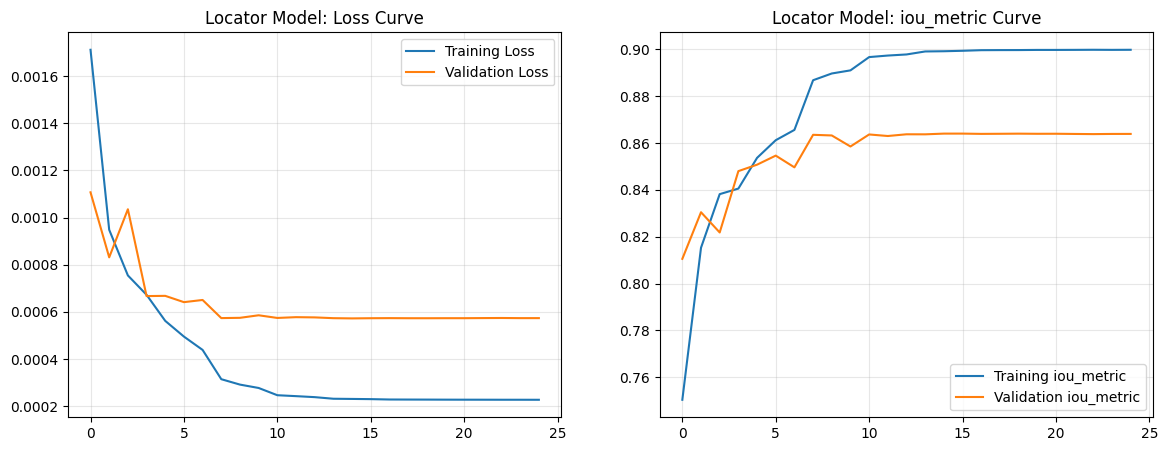

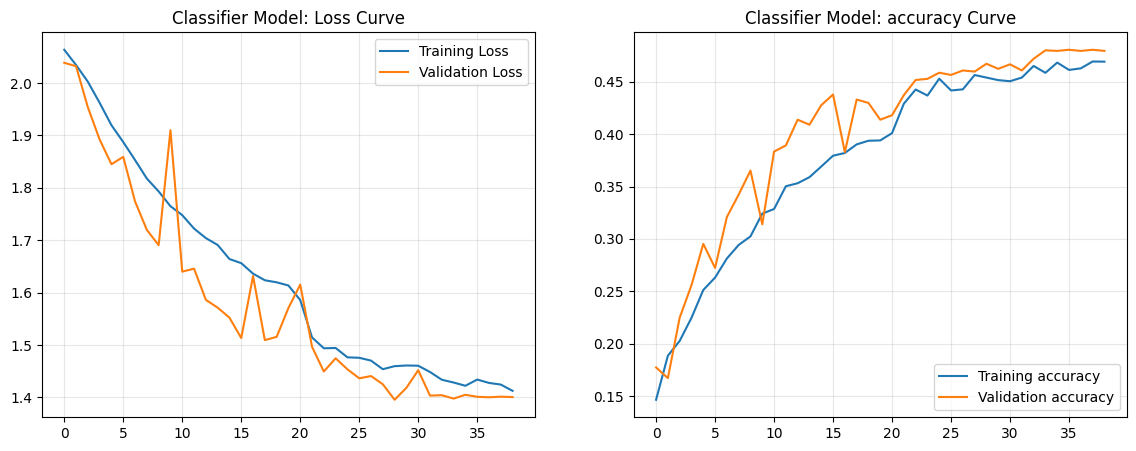

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_learning_curves(history, model_name, metric_name='accuracy'):

    acc = history.history[metric_name]
    val_acc = history.history['val_' + metric_name]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # 1. Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name}: Loss Curve')
    plt.grid(True, alpha=0.3)

    # 2. Metric Plot (Accuracy or IoU)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label=f'Training {metric_name}')
    plt.plot(epochs_range, val_acc, label=f'Validation {metric_name}')
    plt.legend(loc='lower right')
    plt.title(f'{model_name}: {metric_name} Curve')
    plt.grid(True, alpha=0.3)
    
    plt.show()


if 'history_loc' in globals():
    plot_learning_curves(history_loc, "Locator Model", metric_name='iou_metric')
if 'classifier_history' in globals():
    plot_learning_curves(classifier_history, "Classifier Model", metric_name='accuracy')

### **Analysis of the locator and classifier models' learning curve**

1. **The Locator Model**
- **Loss Curve:** The locator model shows an ideal learning curve. Both the training and validation loss decrease rapidly in the first few epochs and then stabilises after. The similar movement of the training and validation loss indicates that the model is not overfitting. Additionally, the gap between the training and validation loss is minimal, this means that the model is generalising well.

- **IoU Curve:** The IoU curve shows a similar pattern to the loss curve. The IoU score increases rapidly in the first few epochs and then stabilises after. It plateaues at a high value and stays flat without movement. This means that the model has learned as much as it can and training it further will not cause any improvements.


2. **The Classifier Model**
- **Loss Curve:** Training and validation loss decrease together from ~2.1 to ~1.45 over 50 epochs. The small gap between curves and their parallel trajectory indicate the model is learning without significant overfitting.

- **Accuracy Curve:** Both curves improve steadily from ~15% to ~48%. The validation accuracy slightly exceeds training accuracy, likely due to natural variation in the data split. The parallel improvement suggests good generalization to unseen faces.


---


## View the predicted bounding box compared to the true bounding box, IoU scores on the test set, and the distribution of IoU scores.

LOCATOR MODEL EVALUATION

Mean IoU: 0.8627
Std IoU: 0.0638
Median IoU: 0.8737
Min IoU: 0.5238
Max IoU: 0.9846
Detection Rate @ IoU≥0.5: 100.0%
Detection Rate @ IoU≥0.6: 99.6%
Detection Rate @ IoU≥0.7: 98.2%
Detection Rate @ IoU≥0.8: 85.3%
Detection Rate @ IoU≥0.9: 31.1%


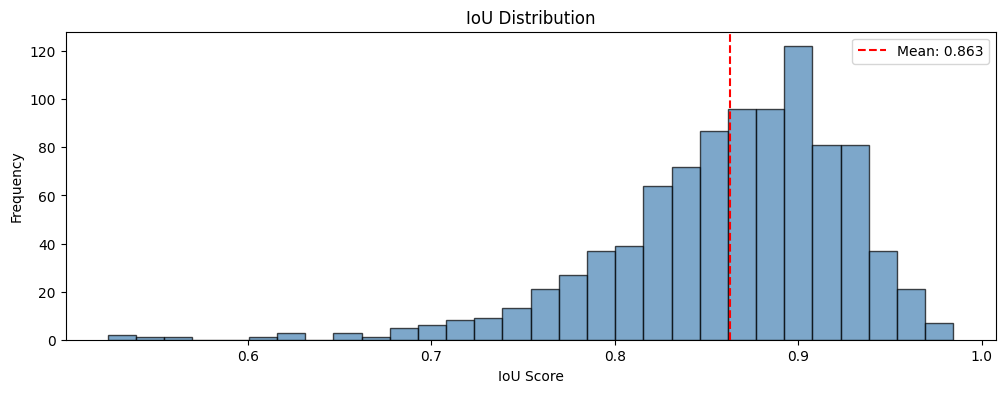

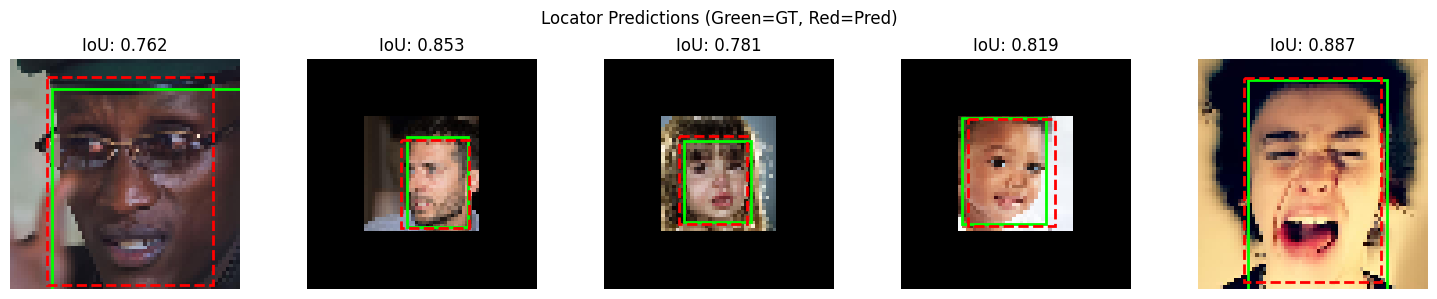

In [209]:
import numpy as np
import matplotlib.pyplot as plt


def calculate_iou(box1, box2):

    # Convert [x, y, w, h] to [x1, y1, x2, y2]
    box1_x1, box1_y1 = box1[0], box1[1]
    box1_x2, box1_y2 = box1[0] + box1[2], box1[1] + box1[3]
    
    box2_x1, box2_y1 = box2[0], box2[1]
    box2_x2, box2_y2 = box2[0] + box2[2], box2[1] + box2[3]
    
    # Intersection
    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Union
    area1 = box1[2] * box1[3]  
    area2 = box2[2] * box2[3]  
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

# Evaluate on test set
print("=" * 50)
print("LOCATOR MODEL EVALUATION")
print("=" * 50)

# Get predictions
locator_predictions = locator_model.predict(X_full_test, verbose=0)

# Calculate IoU for each sample
ious = []
for i in range(len(X_full_test)):
    pred_box = locator_predictions[i]
    true_box = Y_boxes_test[i]
    iou = calculate_iou(pred_box, true_box)
    ious.append(iou)

ious = np.array(ious)

# Print metrics
print(f"\nMean IoU: {ious.mean():.4f}")
print(f"Std IoU: {ious.std():.4f}")
print(f"Median IoU: {np.median(ious):.4f}")
print(f"Min IoU: {ious.min():.4f}")
print(f"Max IoU: {ious.max():.4f}")

# Detection rates at different thresholds
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    rate = (ious >= threshold).mean() * 100
    print(f"Detection Rate @ IoU≥{threshold}: {rate:.1f}%")

# Visualise IoU distribution
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(ious, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(ious.mean(), color='red', linestyle='--', label=f'Mean: {ious.mean():.3f}')
ax.set_xlabel('IoU Score')
ax.set_ylabel('Frequency')
ax.set_title('IoU Distribution')
ax.legend()
plt.show()

# Visualise sample predictions
n_samples = 5
sample_indices = np.random.choice(len(X_full_test), n_samples, replace=False)

fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
for idx, i in enumerate(sample_indices):
    img = X_full_test[i]
    pred = locator_predictions[i]
    true = Y_boxes_test[i]
    
    axes[idx].imshow(img)
    
    h, w = img.shape[:2]
    
\
    rect_true = plt.Rectangle((true[0]*w, true[1]*h), 
                               true[2]*w, true[3]*h,  
                               linewidth=2, edgecolor='lime', facecolor='none')

    rect_pred = plt.Rectangle((pred[0]*w, pred[1]*h), 
                               pred[2]*w, pred[3]*h,  
                               linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
    
    axes[idx].add_patch(rect_true)
    axes[idx].add_patch(rect_pred)
    axes[idx].set_title(f'IoU: {ious[i]:.3f}')
    axes[idx].axis('off')

plt.suptitle('Locator Predictions (Green=GT, Red=Pred)', fontsize=12)
plt.tight_layout()
plt.show()

### **Performance Summary**
The locator model performs exceptionally well with a mean IoU score of 0.864. A standard "successful" detection is defined as IoU >= 0.5, which the model achieves 100% of the time. With 98.2% of IoU scores being above 0.7, the model isn't only accurately finding faces, it also draws a tight box around them, capturing only the important features.

**Key Observations**

The IoU histogram is heavily skewed to the left. This is a good sign as it shows that most predictions are clustered between an IoU score of 0.8 to 0.98. Predictions with low IoU scores are extremely rare outliers, with even the worst performing sample achieving an IoU of 0.504.
The mean IoU score is 0.86 while the median IoU score is 0.87. This shows that the model's typical performance is better than the average score, as the lower mean compared to the median indicates that a small number of lower outliers are slightly dragging down the mean.
The low standard deviation of 0.063 demonstrates consistent and reliable predictions across the test set.

**Verdict**

The model is highly accurate and well-suited to serve as the first stage of the Localisation-Classification pipeline. The 100% detection rate at IoU >= 0.5 ensures that every face is successfully located, while the 85.3% rate at IoU >= 0.8 confirms that the cropped regions will be high-quality inputs for the classifier model, enabling accurate emotion prediction. This is despite the model being trained with faces that are both small and large.


Training   - Loss: 1.3129, Accuracy: 0.5096
Validation - Loss: 1.3954, Accuracy: 0.4672
Test       - Loss: 1.3219, Accuracy: 0.5112


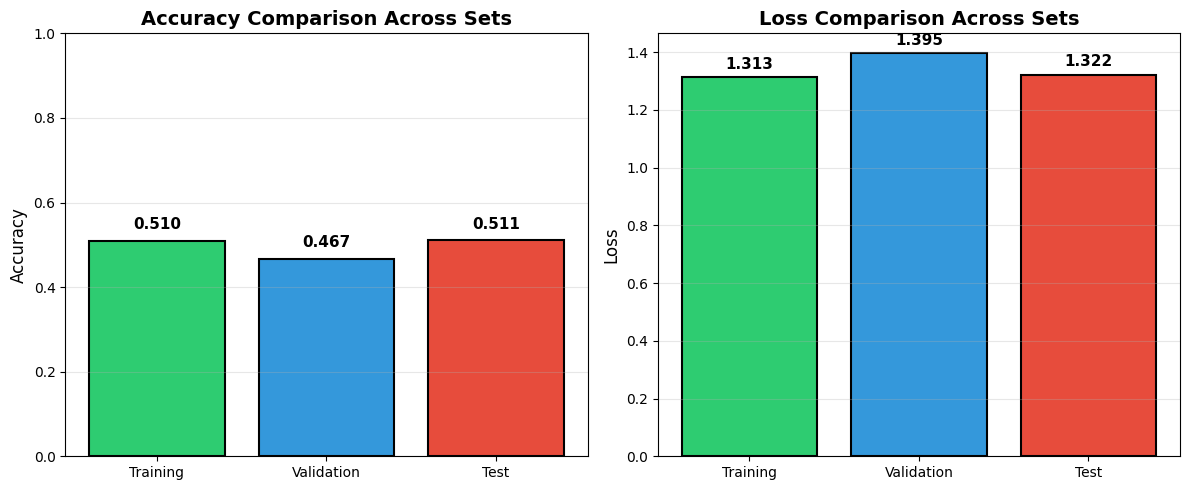

In [210]:


# Training set metrics
train_loss, train_acc = classifier_model.evaluate(X_crops_train, Y_classes_train, verbose=0)

# Validation set metrics  
val_loss, val_acc = classifier_model.evaluate(X_crops_val, Y_classes_val, verbose=0)

# Test set metrics
test_loss, test_accuracy = classifier_model.evaluate(X_crops_test, Y_classes_test, verbose=0)

print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
print(f"Test       - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


# Accuracy comparison
sets = ['Training', 'Validation', 'Test']
accuracies = [train_acc, val_acc, test_accuracy]
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars1 = axes[0].bar(sets, accuracies, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Comparison Across Sets', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars1, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{acc:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Loss comparison
losses = [train_loss, val_loss, test_loss]
bars2 = axes[1].bar(sets, losses, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss Comparison Across Sets', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, loss in zip(bars2, losses):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{loss:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()



30/30 [==============================] - 0s 13ms/step

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

       anger       0.54      0.49      0.51       109
     content       0.58      0.56      0.57       120
     disgust       0.38      0.53      0.45       109
        fear       0.52      0.53      0.53       129
       happy       0.79      0.77      0.78       111
     neutral       0.42      0.40      0.41       117
         sad       0.40      0.30      0.34       127
    surprise       0.50      0.54      0.52       119

    accuracy                           0.51       941
   macro avg       0.52      0.51      0.51       941
weighted avg       0.51      0.51      0.51       941



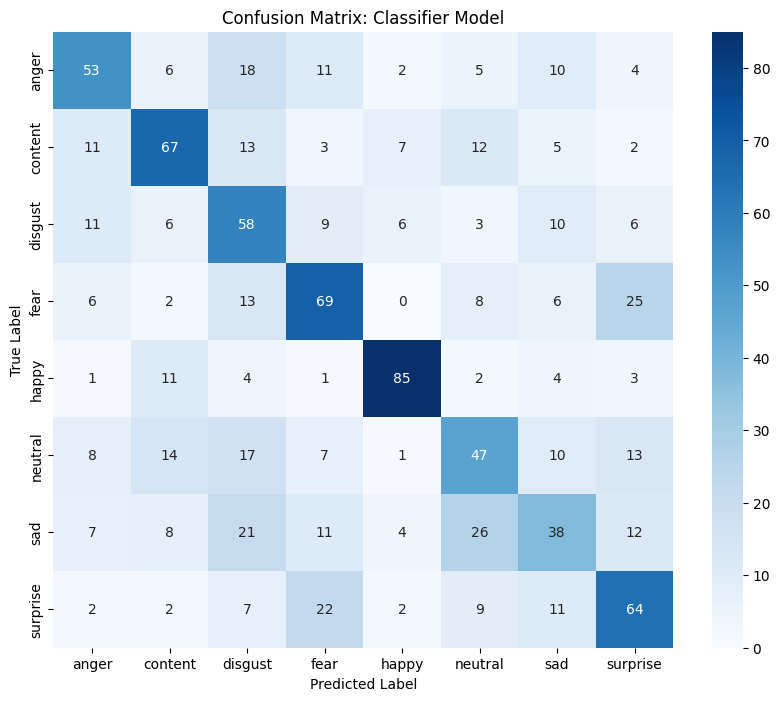


Overall Accuracy: 0.5112 (51.12%)


In [211]:
def evaluate_classifier(model, X_test, y_test, class_names):
    # 1. Get Predictions
    y_pred_probs = model.predict(X_test)
    y_pred_indices = np.argmax(y_pred_probs, axis=1)
    
    y_true_indices = y_test
    
    # 2. Classification Report (Precision, Recall, F1)
    print("\n--- CLASSIFICATION REPORT ---")
    print(classification_report(y_true_indices, y_pred_indices, target_names=class_names))
    
    # 3. Confusion Matrix Heatmap
    cm = confusion_matrix(y_true_indices, y_pred_indices)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: Classifier Model')
    plt.show()
    
    # 4. Overall Accuracy
    accuracy = np.mean(y_pred_indices == y_true_indices)
    print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


evaluate_classifier(classifier_model, X_crops_test, Y_classes_test, classes)

### **Confusion Matrix and Classification Report Analysis**
The confusion matrix shows that the model's performance varies drastically depending on the emotion.

**The Model's Best Performing Classes**
- **Happy:** This is the model's strongest class, with an F1-score of 0.78 and precision of 0.79.
- **Content:** Achieved a solid F1-score of 0.57.

**The Model's "Confusion Cluster"**
- The model struggles to distinguish between subtle negative emotions.
- - **Neutral:** Neutral had a F1-score of 0.41 and it is frequently misclassified as **Disgust (17 Times)** or **Content (14 Times)**.
- - **Sad:** Sad had a F1-score of 0.34 and often misclassified as **Neutral (26 Times)** or **Disgust (21 Times)**.
- **Observation:** These emotions lack "strong" facial features (like a smile or open mouth). They rely on subtle micro-expressions (slight eyebrow tilt, frowning) which are often missed by the model.

**Feature Confusion**
- **Observation:** The class **Fear** has a recall of (0.53) and is most frequently confused with **Surprise (25 Misclassifications)**

- **Insights:** Both emotions have **"widened eyes"** and **"open mouth"** features. The model struggles to find the difference between **"Scared Open Mouth"** or which has a **"Surprised Open Mouth"**.

**Verdict**
- The model performs well for being a simple CNN architecture that has to predict 8 classes. The percentage for a random guess of 8 classes is 12.5%, which the model easily exceeded. This means that the model is not just randomly guessing but is learning and making smart predictions.

## 7. Future Improvements



### 7.1 Critical Analysis of Baseline Performance
The Part 1 baseline models have successfully established a functional two-stage pipeline, though with distinct performance characteristics that dictate the strategy for Part 2:

1.  **Locator Success (The Strong Foundation):**
    * The Locator Model (Model A) proved exceptionally robust, achieving a **100% detection rate at IoU >= 0.5** and a Mean IoU of **0.87**.
    * The learning curves confirm "ideal" behavior, with minimal gap between training and validation loss. This indicates the current architecture is sufficient for the localisation task and does not require major restructuring for Part 2. The focus can remain on maintaining this high-quality input for the classifier.

2.  **Classifier Limitations (The Bottleneck):**
    * While the Classifier (Model B) exceeded the random baseline (12.5%) with **~51% accuracy**, the learning curves reveal a "slow burn" convergence without significant overfitting, suggesting the model is **underfitting** or lacks the capacity/features to distinguish subtle emotions.

    * **The "Confusion Cluster":** The model critically fails to differentiate between subtle negative emotions. Specifically, **Sad** is frequently confused with **Neutral** (26 times), and **Fear** is consistently misclassified as **Surprise** (25 times). This confirms that the baseline CNN is relying on obvious geometric features (like "open mouth") but failing to capture the micro-expressions required for high-fidelity emotion recognition.

    * **Optimisation Stagnation:** Initial experiments with standard regularisation (Dropout, Batch Normalisation) showed no gains or worse results, reinforcing the idea that the baseline architecture itself is the limiting factor.

---

### 7.2 Strategic Improvement Plan for Part 2
To address the capacity limitations of the classifier and the subtle feature confusion, Part 2 will shift focus from simple architectural tuning to **Advanced Architectures** and **Transfer Learning**.

#### A. Advanced Architectures & Transfer Learning
Since the baseline CNN lacks the depth to resolve subtle micro-expressions (e.g., "Surprised" vs. "Scared"), I will explore pre-trained architectures that offer deeper feature extraction capabilities:

* **Pre-Trained Models (ResNet50 / EfficientNet):** These models utilize skip connections and compound scaling to learn significantly more complex hierarchies of features. Using a pre-trained backbone (transfer learning) will allow the model to leverage features learned from massive datasets (ImageNet), potentially resolving the confusion between geometrically similar classes like "Fear" and "Surprise."

* **YOLO (You Only Look Once):** While primarily a detection model, exploring a YOLO-based classifier could offer superior speed-accuracy trade-offs, especially for real-time inference.

* **Vision Transformers (ViT):** Unlike CNNs, ViTs use self-attention mechanisms to model global dependencies. This could be crucial for distinguishing emotions where the relationship between distant facial features (e.g., eyebrows and mouth) defines the class.

* **Geometric Deep Learning (GNNs / Landmarks):** Unlike CNNs which rely on pixel texture, this approach extracts 468 facial landmark coordinates (using MediaPipe) to model the face as a graph. By training a Graph Neural Network (GNN) on these geometric relationships, the model becomes robust to lighting changes and skin tone variations, directly addressing the "Fear vs. Surprise" confusion by analyzing precise shape deformations.

* **Hybrid Ensemble Learning:** Instead of relying on a single architecture, this approach fuses the predictions from multiple distinct models (e.g., the texture-based ResNet and the geometry-based GNN). By averaging their outputs or using a meta-learner (Stacking), the system can cancel out the individual biases of each model, resulting in a "Voting System" that is significantly more robust and accurate than any single part alone.

#### B. Rigorous Hyperparameter Optimisation
To maximise the performance of these complex models, I will move beyond manual tuning to automated frameworks:

* **Automated Tuning (Optuna/Grid Search):** I will implement a structured search for optimal hyperparameters, including learning rates, batch sizes, and optimizer types.

* **Documentation & Justification:** All experiments will be documented with parallel coordinate plots to visualise trade-offs. The final selection will be justified not just by accuracy, but by a balance of precision, recall, and computational cost.



---

# Table of Documentation

## Hyperparameter Tuning & Ablation Study Results

### Locator Model Experiments

| Test No. | Configuration | Metric | Score |
|--------|---------------|--------|-------|
| 1 | Dropout + Batch Normalization | Mean IoU | 0.77 |

### Classifier Model Architecture Experiments

| Test No. | Configuration | Metric | Score |
|--------|---------------|--------|-------|
| 2 | Batch Normalization + Dropout in FCL layers | Accuracy | 0.47 |
| 3 | Batch Normalization in Conv layers only | Accuracy | 0.42 |

### Learning Rate Experiments

| Test No. | Learning Rate | Metric | Score |
|--------|---------------|--------|-------|
| 4 | 0.1 | Accuracy | 0.42 |
| 5 | 0.01 | Accuracy | 0.38 |
| 6 | 0.001 | Accuracy | 0.439 |
| 7 | 0.0001 | Accuracy | 0.438 |

### Optimizer Experiments

| Test No. | Optimizer | Metric | Score |
|--------|-----------|--------|-------|
| 8 | Adam | Accuracy | 0.424 |
| 9 | SGD | Accuracy | 0.35 |
| 10 | RMSprop | Accuracy | 0.436 |

### Batch Size Experiments

| Test No. | Batch Size | Metric | Score |
|--------|------------|--------|-------|
| 11 | 16 | Accuracy | 0.442 |
| 12 | 32 | Accuracy | 0.411 |
| 13 | 64 | Accuracy | 0.383 |
| 14 | 128 | Accuracy | 0.374 |

---

# Appendix: Model Experimentation Playground

This appendix documents various experiments conducted to justify the final model configuration.

**Experiments Conducted:**
1. Different Model Architectures
2. Activation Function Comparison
3. Learning Rate Comparisons
4. Optimizer Comparison
5. Batch Size Comparison

## Locator Model Test (Model with Batch Normalisation and Dropout)

In [ ]:
def build_locator_model():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),


        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4, activation='sigmoid') 
    ])
    
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.Huber(delta=0.1),  
        metrics=[iou_metric]                   
    )
    
    return model

locator_model = build_locator_model()

In [ ]:
print("TRAINING LOCATOR MODEL (Finding Boxes)")

history_loc = locator_model.fit(
    X_full_train, Y_boxes_train,           
    validation_data=(X_full_val, Y_boxes_val), 
    epochs=30,                           
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, reduce_lr],   
    verbose=1
)


TRAINING LOCATOR MODEL (Finding Boxes)
Epoch 1/30
206/206 [==============================] - 3s 11ms/step - loss: 0.0110 - iou_metric: 0.3723 - val_loss: 0.0056 - val_iou_metric: 0.4471 - lr: 0.0010
Epoch 2/30
206/206 [==============================] - 1s 7ms/step - loss: 0.0046 - iou_metric: 0.5859 - val_loss: 0.0028 - val_iou_metric: 0.5842 - lr: 0.0010
Epoch 3/30
206/206 [==============================] - 1s 7ms/step - loss: 0.0036 - iou_metric: 0.6375 - val_loss: 0.0020 - val_iou_metric: 0.6643 - lr: 0.0010
Epoch 4/30
206/206 [==============================] - 1s 7ms/step - loss: 0.0029 - iou_metric: 0.6764 - val_loss: 0.0015 - val_iou_metric: 0.7313 - lr: 0.0010
Epoch 5/30
206/206 [==============================] - 1s 6ms/step - loss: 0.0027 - iou_metric: 0.7011 - val_loss: 0.0014 - val_iou_metric: 0.7525 - lr: 0.0010
Epoch 6/30
206/206 [==============================] - 1s 6ms/step - loss: 0.0026 - iou_metric: 0.7192 - val_loss: 0.0013 - val_iou_metric: 0.7680 - lr: 0.0010
Epoch 

LOCATOR MODEL EVALUATION

Mean IoU: 0.7756
Std IoU: 0.0896
Median IoU: 0.7843
Min IoU: 0.3095
Max IoU: 0.9607
Detection Rate @ IoU≥0.5: 99.3%
Detection Rate @ IoU≥0.6: 97.1%
Detection Rate @ IoU≥0.7: 79.2%
Detection Rate @ IoU≥0.8: 43.9%
Detection Rate @ IoU≥0.9: 6.2%


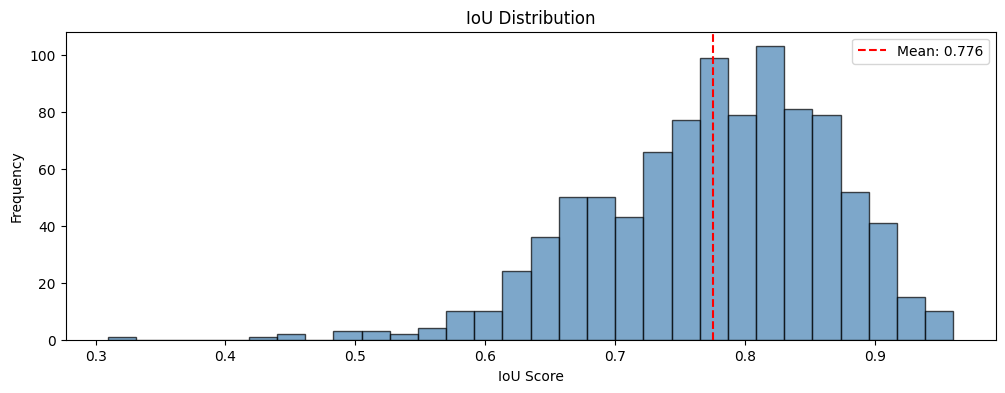

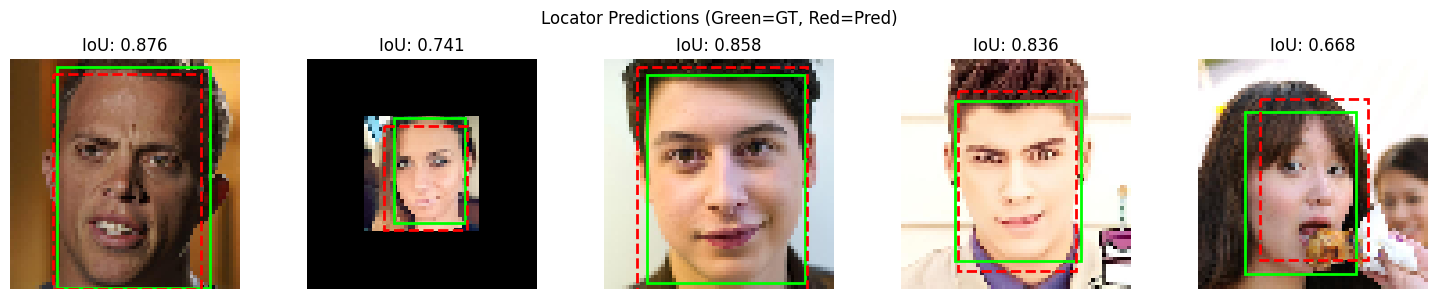

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



def calculate_iou(box1, box2):
    """Calculate Intersection over Union between two boxes.
    Boxes format: [x, y, width, height] (normalized 0-1)
    """
    # Convert [x, y, w, h] to [x1, y1, x2, y2]
    box1_x1, box1_y1 = box1[0], box1[1]
    box1_x2, box1_y2 = box1[0] + box1[2], box1[1] + box1[3]
    
    box2_x1, box2_y1 = box2[0], box2[1]
    box2_x2, box2_y2 = box2[0] + box2[2], box2[1] + box2[3]
    
    # Intersection
    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Union
    area1 = box1[2] * box1[3]  
    area2 = box2[2] * box2[3]  
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

# Evaluate on test set
print("=" * 50)
print("LOCATOR MODEL EVALUATION")
print("=" * 50)

# Get predictions
locator_predictions = locator_model.predict(X_full_test, verbose=0)

# Calculate IoU for each sample
ious = []
for i in range(len(X_full_test)):
    pred_box = locator_predictions[i]
    true_box = Y_boxes_test[i]
    iou = calculate_iou(pred_box, true_box)
    ious.append(iou)

ious = np.array(ious)

# Print metrics
print(f"\nMean IoU: {ious.mean():.4f}")
print(f"Std IoU: {ious.std():.4f}")
print(f"Median IoU: {np.median(ious):.4f}")
print(f"Min IoU: {ious.min():.4f}")
print(f"Max IoU: {ious.max():.4f}")

# Detection rates at different thresholds
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    rate = (ious >= threshold).mean() * 100
    print(f"Detection Rate @ IoU≥{threshold}: {rate:.1f}%")

# Visualise IoU distribution
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(ious, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(ious.mean(), color='red', linestyle='--', label=f'Mean: {ious.mean():.3f}')
ax.set_xlabel('IoU Score')
ax.set_ylabel('Frequency')
ax.set_title('IoU Distribution')
ax.legend()
plt.show()

# Visualise sample predictions
n_samples = 5
sample_indices = np.random.choice(len(X_full_test), n_samples, replace=False)

fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
for idx, i in enumerate(sample_indices):
    img = X_full_test[i]
    pred = locator_predictions[i]
    true = Y_boxes_test[i]
    
    axes[idx].imshow(img)
    
    h, w = img.shape[:2]
    
    rect_true = plt.Rectangle((true[0]*w, true[1]*h), 
                               true[2]*w, true[3]*h,  
                               linewidth=2, edgecolor='lime', facecolor='none')

    rect_pred = plt.Rectangle((pred[0]*w, pred[1]*h), 
                               pred[2]*w, pred[3]*h,  
                               linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
    
    axes[idx].add_patch(rect_true)
    axes[idx].add_patch(rect_pred)
    axes[idx].set_title(f'IoU: {ious[i]:.3f}')
    axes[idx].axis('off')

plt.suptitle('Locator Predictions (Green=GT, Red=Pred)', fontsize=12)
plt.tight_layout()
plt.show()

## Classifier Model 1 Test (Batch Normalisation and Dropout in FCL layers)

In [57]:
def build_classifier_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(8, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),


        layers.Conv2D(32, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

classifier_model = build_classifier_model(len(CLASS_NAMES))


In [ ]:

print("TRAINING CLASSIFIER MODEL (Naming Objects)")

classifier_history = classifier_model.fit(
    train_generator,                         
    epochs=100,
    validation_data=(X_crops_val, Y_classes_val),  
    callbacks=[early_stop,reduce_lr],
    verbose=1,
)



TRAINING CLASSIFIER MODEL (Naming Objects)
Epoch 1/100
206/206 [==============================] - 15s 65ms/step - loss: 2.0876 - accuracy: 0.1601 - val_loss: 2.0751 - val_accuracy: 0.1474
Epoch 2/100
206/206 [==============================] - 9s 41ms/step - loss: 2.0403 - accuracy: 0.1810 - val_loss: 2.0750 - val_accuracy: 0.1538
Epoch 3/100
206/206 [==============================] - 12s 56ms/step - loss: 2.0187 - accuracy: 0.1962 - val_loss: 2.1592 - val_accuracy: 0.1404
Epoch 4/100
206/206 [==============================] - 8s 39ms/step - loss: 2.0125 - accuracy: 0.2047 - val_loss: 2.2138 - val_accuracy: 0.1324
Epoch 5/100
206/206 [==============================] - 11s 54ms/step - loss: 1.9985 - accuracy: 0.2187 - val_loss: 2.1559 - val_accuracy: 0.1639
Epoch 6/100
206/206 [==============================] - 22s 104ms/step - loss: 1.9953 - accuracy: 0.2122 - val_loss: 2.0501 - val_accuracy: 0.2200
Epoch 7/100
206/206 [==============================] - 23s 111ms/step - loss: 1.9875 - a

30/30 [==============================] - 1s 16ms/step

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

       anger       0.40      0.63      0.49       109
     content       0.45      0.57      0.50       120
     disgust       0.48      0.36      0.41       109
        fear       0.50      0.53      0.52       129
       happy       0.80      0.60      0.69       111
     neutral       0.43      0.44      0.44       117
         sad       0.28      0.24      0.26       127
    surprise       0.53      0.37      0.44       119

    accuracy                           0.47       941
   macro avg       0.48      0.47      0.47       941
weighted avg       0.48      0.47      0.46       941



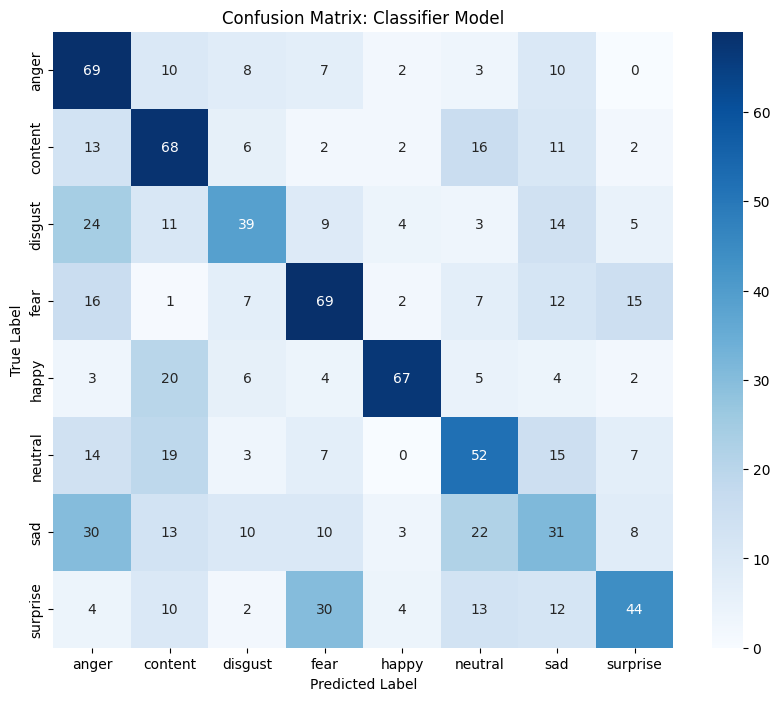


Overall Accuracy: 0.4665 (46.65%)


In [ ]:
def evaluate_classifier(model, X_test, y_test, class_names):
    # 1. Get Predictions
    y_pred_probs = model.predict(X_test)
    y_pred_indices = np.argmax(y_pred_probs, axis=1)
    

    y_true_indices = y_test
    
    # 2. Classification Report (Precision, Recall, F1)
    print("\n--- CLASSIFICATION REPORT ---")
    print(classification_report(y_true_indices, y_pred_indices, target_names=class_names))
    
    # 3. Confusion Matrix Heatmap
    cm = confusion_matrix(y_true_indices, y_pred_indices)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: Classifier Model')
    plt.show()
    
    # 4. Overall Accuracy
    accuracy = np.mean(y_pred_indices == y_true_indices)
    print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


evaluate_classifier(classifier_model, X_crops_test, Y_classes_test, classes)

## Classifier Model 2 Test (Batch Normalisation in Conv Layers)

In [64]:
def build_classifier_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(8, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),


        layers.Conv2D(32, (3, 3), padding='same'),
        
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        # layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

classifier_model = build_classifier_model(len(CLASS_NAMES))


In [ ]:

print("TRAINING CLASSIFIER MODEL (Naming Objects)")

classifier_history = classifier_model.fit(
    train_generator,                         
    validation_data=(X_crops_val, Y_classes_val),  
    callbacks=[early_stop,reduce_lr],
    verbose=1,
)



TRAINING CLASSIFIER MODEL (Naming Objects)
Epoch 1/100
206/206 [==============================] - 7s 30ms/step - loss: 2.1166 - accuracy: 0.1613 - val_loss: 2.1748 - val_accuracy: 0.1511
Epoch 2/100
206/206 [==============================] - 6s 28ms/step - loss: 2.0380 - accuracy: 0.1823 - val_loss: 1.9921 - val_accuracy: 0.2232
Epoch 3/100
206/206 [==============================] - 6s 29ms/step - loss: 2.0071 - accuracy: 0.2078 - val_loss: 1.9838 - val_accuracy: 0.2226
Epoch 4/100
206/206 [==============================] - 6s 28ms/step - loss: 1.9831 - accuracy: 0.2116 - val_loss: 2.0342 - val_accuracy: 0.2018
Epoch 5/100
206/206 [==============================] - 6s 28ms/step - loss: 1.9452 - accuracy: 0.2347 - val_loss: 2.1146 - val_accuracy: 0.1826
Epoch 6/100
206/206 [==============================] - 6s 27ms/step - loss: 1.9074 - accuracy: 0.2536 - val_loss: 1.8504 - val_accuracy: 0.2808
Epoch 7/100
206/206 [==============================] - 6s 30ms/step - loss: 1.8777 - accuracy

30/30 [==============================] - 0s 14ms/step

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

       anger       0.33      0.55      0.41       109
     content       0.51      0.43      0.47       120
     disgust       0.26      0.22      0.24       109
        fear       0.46      0.61      0.53       129
       happy       0.74      0.66      0.70       111
     neutral       0.37      0.27      0.32       117
         sad       0.32      0.19      0.24       127
    surprise       0.42      0.46      0.44       119

    accuracy                           0.42       941
   macro avg       0.43      0.42      0.42       941
weighted avg       0.43      0.42      0.42       941



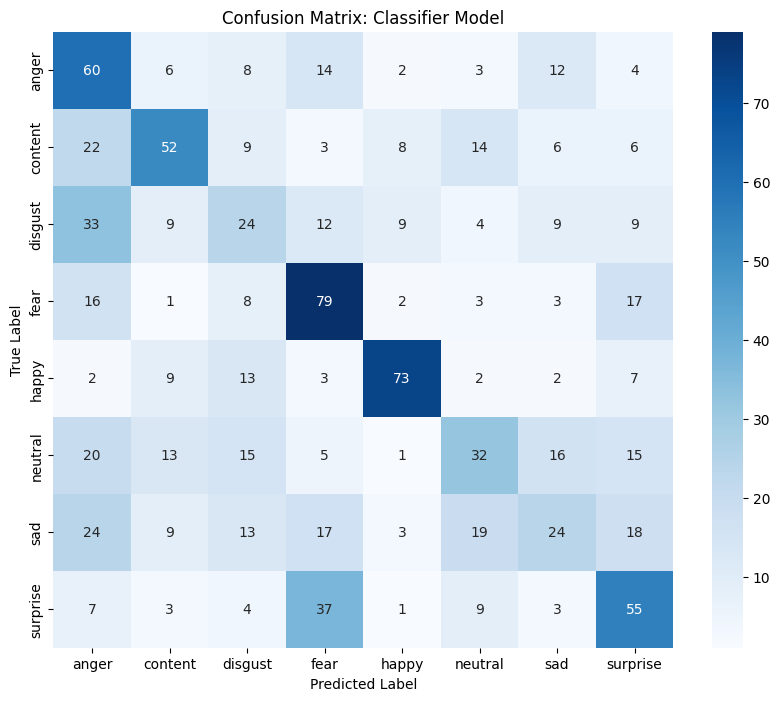


Overall Accuracy: 0.4240 (42.40%)


In [ ]:
def evaluate_classifier(model, X_test, y_test, class_names):
    # 1. Get Predictions
    y_pred_probs = model.predict(X_test)
    y_pred_indices = np.argmax(y_pred_probs, axis=1)
    
    y_true_indices = y_test
    
    # 2. Classification Report (Precision, Recall, F1)
    print("\n--- CLASSIFICATION REPORT ---")
    print(classification_report(y_true_indices, y_pred_indices, target_names=class_names))
    
    # 3. Confusion Matrix Heatmap
    cm = confusion_matrix(y_true_indices, y_pred_indices)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: Classifier Model')
    plt.show()
    
    # 4. Overall Accuracy
    accuracy = np.mean(y_pred_indices == y_true_indices)
    print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


evaluate_classifier(classifier_model, X_crops_test, Y_classes_test, classes)

## Learning Rate Tests


Testing Learning Rate: 0.0001
Epoch 1/20
206/206 [==============================] - 7s 31ms/step - loss: 2.0766 - accuracy: 0.1273 - val_loss: 2.0800 - val_accuracy: 0.1297 - lr: 0.0010
Epoch 2/20
206/206 [==============================] - 6s 30ms/step - loss: 2.0710 - accuracy: 0.1463 - val_loss: 2.0706 - val_accuracy: 0.1484 - lr: 0.0010
Epoch 3/20
206/206 [==============================] - 6s 29ms/step - loss: 2.0322 - accuracy: 0.1877 - val_loss: 2.0285 - val_accuracy: 0.1933 - lr: 0.0010
Epoch 4/20
206/206 [==============================] - 6s 29ms/step - loss: 2.0162 - accuracy: 0.2066 - val_loss: 1.9694 - val_accuracy: 0.2296 - lr: 0.0010
Epoch 5/20
206/206 [==============================] - 6s 29ms/step - loss: 1.9883 - accuracy: 0.2131 - val_loss: 2.0042 - val_accuracy: 0.2104 - lr: 0.0010
Epoch 6/20
206/206 [==============================] - 6s 28ms/step - loss: 1.9559 - accuracy: 0.2283 - val_loss: 1.8697 - val_accuracy: 0.2760 - lr: 0.0010
Epoch 7/20
206/206 [=============

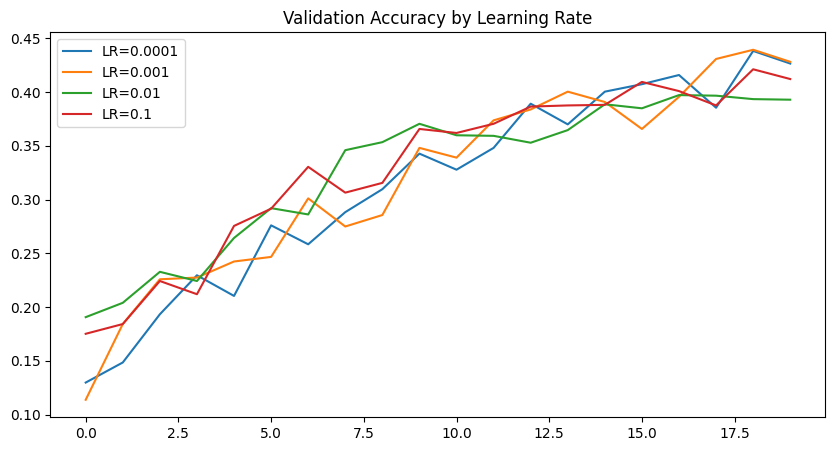

In [ ]:


def build_classifier_model_lr(num_classes,lr):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(8, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),


        layers.Conv2D(32, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        # layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



learning_rates = [0.0001, 0.001, 0.01, 0.1]
lr_results = {}

for lr in learning_rates:
    print(f"\nTesting Learning Rate: {lr}")
    model_lr = build_classifier_model_lr(num_classes=len(CLASS_NAMES),lr=lr)
    history_lr = model_lr.fit(
    train_generator,                          
    epochs=20,
    validation_data=(X_crops_val, Y_classes_val), 
    callbacks=[early_stop,reduce_lr],
    verbose=1,
)
    lr_results[lr] = {'val_acc': history_lr.history['val_accuracy'][-1], 'history': history_lr}

# Plot results
fig, ax = plt.subplots(figsize=(10, 5))
for lr, result in lr_results.items():
    ax.plot(result['history'].history['val_accuracy'], label=f'LR={lr}')
ax.set_title('Validation Accuracy by Learning Rate')
ax.legend()
plt.show()

## Activation Function Comparison

In [ ]:

def build_classifier_model_af(num_classes,act):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(8, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation(act),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation(act),
        layers.MaxPooling2D((2, 2)),


        layers.Conv2D(32, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation(act),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation(act),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128),
        # layers.BatchNormalization(),
        layers.Activation(act),
        # layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
     loss='sparse_categorical_crossentropy',
     metrics=['accuracy'])
    return model


activations = ['relu', 'tanh', 'sigmoid', 'elu']
act_results = {}

for act in activations:
    print(f"\nTesting: {act}")
    model = build_classifier_model(len(CLASS_NAMES),act)
        
    history_act = model.fit(
    train_generator,                         
    epochs=20,
    validation_data=(X_crops_val, Y_classes_val),  
    callbacks=[early_stop,reduce_lr],
    verbose=1,
)
    act_results[act] = history_act.history['val_accuracy'][-1]

print("\nResults:", act_results)


Testing: relu
Epoch 1/20
206/206 [==============================] - 15s 67ms/step - loss: 2.0703 - accuracy: 0.1508 - val_loss: 2.0703 - val_accuracy: 0.1511 - lr: 0.0010
Epoch 2/20
206/206 [==============================] - 10s 48ms/step - loss: 2.0458 - accuracy: 0.1742 - val_loss: 2.0197 - val_accuracy: 0.1981 - lr: 0.0010
Epoch 3/20
206/206 [==============================] - 9s 43ms/step - loss: 2.0208 - accuracy: 0.1965 - val_loss: 2.0805 - val_accuracy: 0.1901 - lr: 0.0010
Epoch 4/20
206/206 [==============================] - 9s 41ms/step - loss: 1.9871 - accuracy: 0.2117 - val_loss: 1.9749 - val_accuracy: 0.2290 - lr: 0.0010
Epoch 5/20
206/206 [==============================] - 9s 45ms/step - loss: 1.9456 - accuracy: 0.2382 - val_loss: 1.9621 - val_accuracy: 0.2365 - lr: 0.0010
Epoch 6/20
206/206 [==============================] - 9s 42ms/step - loss: 1.9045 - accuracy: 0.2503 - val_loss: 1.8702 - val_accuracy: 0.2760 - lr: 0.0010
Epoch 7/20
206/206 [===========================

While the initial results show that tanh is better, after training for 100 epochs, the results show that relu performs significantly better with an accuracy of 0.5 while tanh had an accuracy of 0.45

## Optimiser Comparison

In [ ]:

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

optimizers = {'Adam': Adam(0.001), 'SGD': SGD(0.01, momentum=0.9), 'RMSprop': RMSprop(0.001)}
opt_results = {}

def build_classifier_model_opt(num_classes,opt):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(8, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(16, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),


        layers.Conv2D(32, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128),
        # layers.BatchNormalization(),
        layers.Activation('relu'),
        # layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=opt,
     loss='sparse_categorical_crossentropy',
     metrics=['accuracy'])
    return model


for name, opt in optimizers.items():
    print(f"\nTesting: {name}")
    model = build_classifier_model(len(CLASS_NAMES),opt)
    history_opt = model.fit(
    train_generator,                         
    epochs=20,
    validation_data=(X_crops_val, Y_classes_val),  
    callbacks=[early_stop,reduce_lr],
    verbose=1,
)
    opt_results[name] = history_opt.history['val_accuracy'][-1]

print("\nResults:", opt_results)


Testing: Adam
Epoch 1/20
206/206 [==============================] - 8s 36ms/step - loss: 2.0713 - accuracy: 0.1420 - val_loss: 2.1188 - val_accuracy: 0.1452 - lr: 0.0010
Epoch 2/20
206/206 [==============================] - 7s 33ms/step - loss: 2.0369 - accuracy: 0.1731 - val_loss: 2.0421 - val_accuracy: 0.1762 - lr: 0.0010
Epoch 3/20
206/206 [==============================] - 7s 34ms/step - loss: 2.0107 - accuracy: 0.2046 - val_loss: 1.9905 - val_accuracy: 0.2242 - lr: 0.0010
Epoch 4/20
206/206 [==============================] - 7s 34ms/step - loss: 1.9779 - accuracy: 0.2201 - val_loss: 1.9283 - val_accuracy: 0.2360 - lr: 0.0010
Epoch 5/20
206/206 [==============================] - 7s 33ms/step - loss: 1.9269 - accuracy: 0.2413 - val_loss: 1.8822 - val_accuracy: 0.2771 - lr: 0.0010
Epoch 6/20
206/206 [==============================] - 7s 33ms/step - loss: 1.8902 - accuracy: 0.2555 - val_loss: 1.8919 - val_accuracy: 0.2814 - lr: 0.0010
Epoch 7/20
206/206 [=============================

### After trying out Adam vs RMSprop in the proper training settings (100 Epochs), we found that RMSprop is better for this task. First visualisation is Adam. Second is RMSprop.

Training   - Loss: 1.3602, Accuracy: 0.4938
Validation - Loss: 1.4189, Accuracy: 0.4634
Test       - Loss: 1.3936, Accuracy: 0.4803


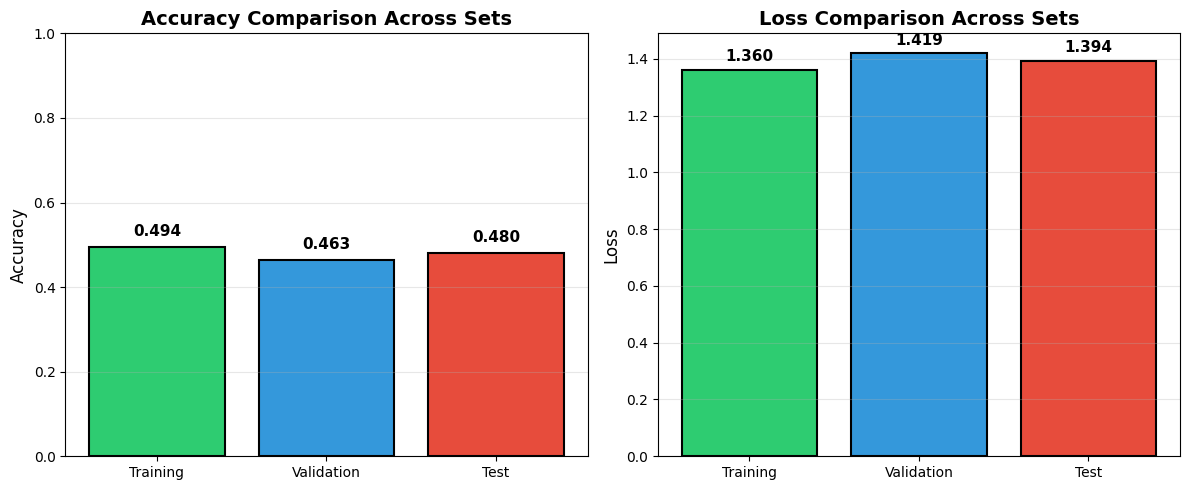

In [ ]:


# Training set metrics
train_loss, train_acc = classifier_model.evaluate(X_crops_train, Y_classes_train, verbose=0)

# Validation set metrics  
val_loss, val_acc = classifier_model.evaluate(X_crops_val, Y_classes_val, verbose=0)

# Test set metrics
test_loss, test_accuracy = classifier_model.evaluate(X_crops_test, Y_classes_test, verbose=0)

print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
print(f"Test       - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")



fig, axes = plt.subplots(1, 2, figsize=(12, 5))


# Accuracy comparison
sets = ['Training', 'Validation', 'Test']
accuracies = [train_acc, val_acc, test_accuracy]
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars1 = axes[0].bar(sets, accuracies, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Comparison Across Sets', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars1, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{acc:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Loss comparison
losses = [train_loss, val_loss, test_loss]
bars2 = axes[1].bar(sets, losses, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss Comparison Across Sets', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, loss in zip(bars2, losses):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{loss:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()



Training   - Loss: 1.3534, Accuracy: 0.5008
Validation - Loss: 1.4123, Accuracy: 0.4789
Test       - Loss: 1.4073, Accuracy: 0.4697


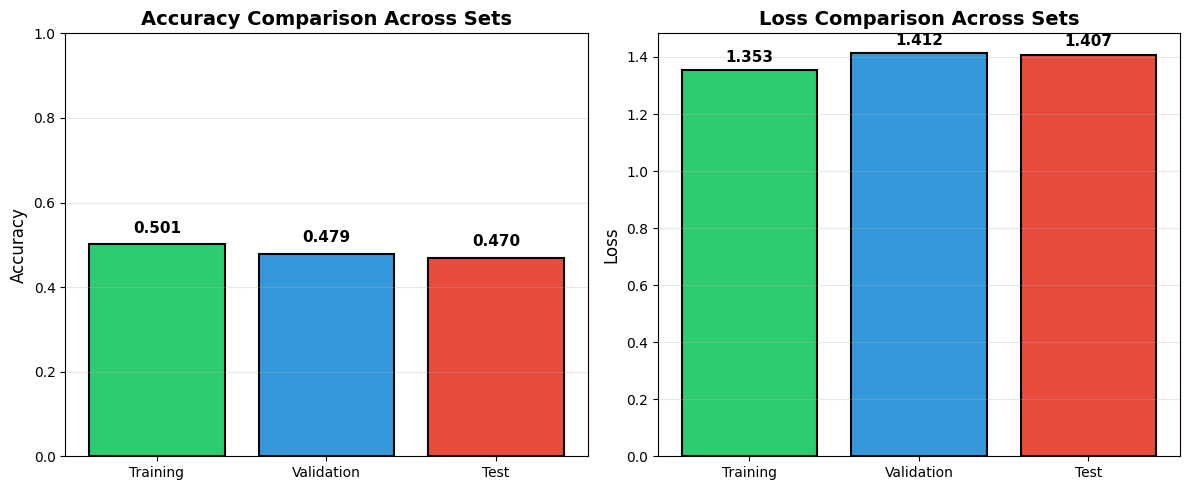

In [ ]:


# Training set metrics
train_loss, train_acc = classifier_model.evaluate(X_crops_train, Y_classes_train, verbose=0)

# Validation set metrics  
val_loss, val_acc = classifier_model.evaluate(X_crops_val, Y_classes_val, verbose=0)

# Test set metrics
test_loss, test_accuracy = classifier_model.evaluate(X_crops_test, Y_classes_test, verbose=0)

print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
print(f"Test       - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")



fig, axes = plt.subplots(1, 2, figsize=(12, 5))


# Accuracy comparison
sets = ['Training', 'Validation', 'Test']
accuracies = [train_acc, val_acc, test_accuracy]
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars1 = axes[0].bar(sets, accuracies, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Comparison Across Sets', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars1, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{acc:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Loss comparison
losses = [train_loss, val_loss, test_loss]
bars2 = axes[1].bar(sets, losses, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss Comparison Across Sets', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, loss in zip(bars2, losses):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{loss:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()



## Batch Size Comparison

In [171]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_sizes = [16, 32, 64, 128]
batch_results = {}


for batch_size in batch_sizes:
    print(f"\n{'='*50}")
    print(f"Testing Batch Size: {batch_size}")
    print(f"{'='*50}")
    
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Create generator with current batch size
    train_generator = train_datagen.flow(
        X_crops_train, Y_classes_train,
        batch_size=batch_size
    )
    
    model = build_classifier_model(len(CLASS_NAMES))
    
    history_batch = model.fit(
        train_generator,
        steps_per_epoch=len(X_crops_train) // batch_size,
        epochs=20,
        validation_data=(X_crops_val, Y_classes_val),
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    batch_results[batch_size] = {
        'val_accuracy': history_batch.history['val_accuracy'][-1],
        'val_loss': history_batch.history['val_loss'][-1],
        'epochs_trained': len(history_batch.history['val_accuracy'])
    }

# Print Results
print("\n" + "="*60)
print("BATCH SIZE COMPARISON RESULTS")
print("="*60)
print(f"\n{'Batch Size':<15} {'Val Accuracy':<15} {'Val Loss':<15} {'Epochs':<10}")
print("-" * 55)
for batch_size, results in batch_results.items():
    print(f"{batch_size:<15} {results['val_accuracy']:<15.4f} {results['val_loss']:<15.4f} {results['epochs_trained']:<10}")

best_batch = max(batch_results, key=lambda x: batch_results[x]['val_accuracy'])
print(f"\n Best Batch Size: {best_batch} (Val Accuracy: {batch_results[best_batch]['val_accuracy']:.4f})")


Testing Batch Size: 16
Epoch 1/20
411/411 [==============================] - 9s 19ms/step - loss: 2.0774 - accuracy: 0.1361 - val_loss: 2.0479 - val_accuracy: 0.1634 - lr: 0.0010
Epoch 2/20
411/411 [==============================] - 7s 17ms/step - loss: 2.0398 - accuracy: 0.1775 - val_loss: 1.9819 - val_accuracy: 0.2013 - lr: 0.0010
Epoch 3/20
411/411 [==============================] - 8s 19ms/step - loss: 1.9938 - accuracy: 0.2154 - val_loss: 1.9151 - val_accuracy: 0.2435 - lr: 0.0010
Epoch 4/20
411/411 [==============================] - 8s 18ms/step - loss: 1.9607 - accuracy: 0.2334 - val_loss: 1.8500 - val_accuracy: 0.2771 - lr: 0.0010
Epoch 5/20
411/411 [==============================] - 7s 17ms/step - loss: 1.9126 - accuracy: 0.2457 - val_loss: 1.8266 - val_accuracy: 0.2920 - lr: 0.0010
Epoch 6/20
411/411 [==============================] - 7s 18ms/step - loss: 1.8755 - accuracy: 0.2710 - val_loss: 1.7719 - val_accuracy: 0.3150 - lr: 0.0010
Epoch 7/20
411/411 [====================